# Application of the Neutron Yields Model Pair. 

In [1]:
import numpy as np
from tensorflow import keras
import datetime
import pandas as pd
import tqdm
from scipy import signal

import matplotlib.pyplot as plt

# linestyles
lines = ['k-', 'b--', 'r-.', 'k:','b-', 'r--', 'k-.', 'b:','r-', 'k--', 'b-.', 'r:']

In [2]:
pwd()

'/home/benedikt/Dokumente/Surrogate/surrogate-modeling-skripts/neutronyield'

In [3]:
# Step 1: Import Model and define needed Parameters:
## Load the model:
neutron_Emax = keras.models.load_model('./neutron_model/Emax.h5') 
neutron_yield = keras.models.load_model('./neutron_model/spectrum_scaled.h5') 
NormFactor = -16.05053051577077

## The model predicts: log10(y)/NormFactor, where NormFactor = min(log10(y)).
## This scales the output from 0 to something larger and makes the network more stable during training.

In [4]:
# This cell constructs the data for the error estimation:
modellist = [0,1,2,3,4,5,6,7,8]
normlist = [-16.2795554642226,-15.9784334432444,-16.6230863942024,-16.9577784063091,-16.8752792953913,-16.1652535977474,-16.5273581123647,-15.3819298045961,-16.4534124034296]
# Organise with a dictionary: 
MC_neutron_yield = {}
for i in modellist:
    MC_neutron_yield['model_'+str(i)] = keras.models.load_model('./neutron_model/spectrum_scaled_random_'+str(i)+'.h5')
    MC_neutron_yield['model_'+str(i)+'_norm'] = normlist[i]
    
MC_neutron_yield.keys()

dict_keys(['model_0', 'model_0_norm', 'model_1', 'model_1_norm', 'model_2', 'model_2_norm', 'model_3', 'model_3_norm', 'model_4', 'model_4_norm', 'model_5', 'model_5_norm', 'model_6', 'model_6_norm', 'model_7', 'model_7_norm', 'model_8', 'model_8_norm'])

In [5]:
# extract the neuron count from the keras model.
if False:
    test = neutron_yield.get_config()
    neuron_count = []
    for i in range(0,len(test['layers'])):
        if i == 0:
            neuron_count.append(test['layers'][i]['config']['batch_input_shape'][1])
        else:
            neuron_count.append(test['layers'][i]['config']['units'])

    neuron_count

In [6]:
#test['layers'][0]['config']['batch_input_shape'][1]#['units']

In [7]:
# Step 2: Define input parameters
## The difference between the spectrum and the Emax model is only one variable.
## I define a function which will return a data array which can be passed to the network.

## The neutron cut-off can be overestimated, this has to be dealt with.
## A good correction is the Q-Value.
# {'li': '000', 'lif': '001','be': '010','va':'011','ta': '100' }
ProtonQValue = {'000':-1.88,'001':(-1.65-4.02)/2,
                '010':-1.85,'011':-1.54,'100':-0.97}
DeuterQValue = {'000':15.03,'001':(15.03+10.62)/2,
                '010':+4.36,'011':+8.28,'100':+4.87}

def san_input(En, Ep, dL, Theta, Proj, Conv, display_output=True):
    """
    Function to sanitize and format the input for the neutron models!

    Parameters
    ----------
    En : numpy array (n,)
        Array for the neutron bin energies, values should be between 0 and 150 MeV.
    Ep : float
        Projectile Energy in MeV, should be between 3 and 97 MeV.
    dL : float
        Converter length in mm, should be between 0 and 105 mm 
    Theta : float
        Scattering angle in degree, cylindrical symmetry applies; value between 0 and 180 degree.
    Proj : int or str
        Proton or deuteron as string or [0,1], 0:Proton, 1:Deuteron
    Conv : str 
        Either Material from Material List or binary code str. (000, 001,010,011,100).
    Returns
    -------
    x_in : numpy array (m,8)
        Normalized and organized m x 8 numpy array.
        m = n - k, where is the number of invalid energy bin values. 
        Can be passed directly to the evaluate function.
    """
    
    # Converter Length: (in mm)
    if np.abs(dL) > 105: 
        if display_output: print('Warning: Converter is to long!')
        if display_output: print('Converter set to the maximum: 105 mm')
        dL = 105
    elif dL < 0:
        if display_output: print('Warning: Converterlength can not be negative!')
        if display_output: print('Applying absolute on the value!')
        dL = np.abs(dL)
        
    if display_output: print('Converter Lengh:')
    if display_output: print(dL)
        
    # Scatterin Angle:
    if Theta <= 180:
        TempTheta = Theta
    elif Theta > 180: 
        TempTheta = 180 - (Theta-180)
    elif Theta > 360:
        if display_output: print('Warning: Circle has only 360 degree!')
        if display_output: print('Theta is set to default 0 degree!')
        TempTheta = 0
    if display_output: print('Scattering Angle Used:')
    if display_output: print(TempTheta)
    
    # Projectile types: 
    if Proj not in [0,1]:
        # Proj needs to be converted!
        # convert strings to lower case such that it is case insensitve.
        if Proj.lower() == 'deuter':
            TempProj = 1
        elif Proj.lower() == 'proton':
            TempProj = 0
        else: 
            if display_output: print('Warning: Undefined Projectile')
            if display_output: print('Assuming protons as default!')
            TempProj = 0
    else:
        TempProj = Proj
    
    if int(TempProj)==0 and display_output: print('Identified Proton Projectile.')
    elif int(TempProj)==1 and display_output: print('Identified Deuterium Projectile.')
            
    # Converter types: 
    ## Element dict:
    elemDict = {'li': '000', 'lif': '001','be': '010','va':'011','ta': '100' }
    InvertelemDict = {'000':'li', '001':'lif','010':'be','011':'va','100':'ta' }
    # check the input: 
    if len(Conv) > 3 or len(Conv) == 2:
        if Conv[0:2].lower() in list(elemDict.keys()):
            TempConv = elemDict[Conv.lower()]
        else: 
            if display_output: print('Warning: Undefined Converter Material')
            if display_output: print('Assuming Lithium as default!')
            TempConv = elemDict['li']
    
    elif len(Conv) == 3: 
        if Conv.lower() == 'lif':
            TempConv = elemDict[Conv.lower()]
        if Conv in ['000','001','010','011','100']:
            TempConv = Conv
    else:
        if display_output: print('Warning: Undefined Converter Material')
        if display_output: print('Assuming Lithium as default!')
        TempConv = elemDict['li']
    
    if display_output: print('Target identified as: ' + InvertelemDict[TempConv])
        
    # We call the model for one dedicated projectile Energy. 
    # Looping over several energies should be done externally. 
    # Projectile Energy: (in MeV)
    
    if np.abs(Ep) > 97: 
        if display_output: print('Warning: Projectile energy is to high!')
        if display_output: print('Projectile energy set to the maximum: 97 MeV')
        Ep = 97
        
    elif np.abs(Ep) < 3: 
        if display_output: print('Warning: Projectile energy is to low!')
        if display_output: print('Projectile energy set to the minimum: 03 MeV')
        Ep = 3

    else:
        Ep = np.abs(Ep)
        
    if display_output: print('Projectile Energy:')
    if display_output: print(Ep)
    
    # Neutron energy bins, numpy array in the range [0,150] MeV
    if np.max(En) > 150:
        if display_output: print('Warning: Energy bin values are to high!')
        if display_output: print('Energy bin values > 150 MeV are cut!')
        En = En[En<=150]
    if np.min(En) < 0:
        if display_output: print('Warning: Energy bin values can not be negative!')
        if display_output: print('Energy bin values < 0 MeV are cut!')
        En = En[En > 0]
    
    # normalize and create array to feed in the model
    x_in = np.zeros((len(En),8))
    
    for i in range(len(En)):
        x_in[i,0] = En[i]           /150 # neutron energy bin
        x_in[i,1] = Ep              /100 # projectile energy
        x_in[i,2] = dL              /105 # length
        x_in[i,3] = TempTheta       /180 # angle
        x_in[i,4] = TempProj             # OHE P
        x_in[i,5] = int(TempConv[0])     # OHE T1
        x_in[i,6] = int(TempConv[1])     # OHE T2
        x_in[i,7] = int(TempConv[2])     # OHE T3

    return x_in
    
def calc_spectrum(x_in, correct_cutoff = False, uncertainty=True):
    """
    Function to calculate the neutron spectrum for parameters defined by x_in.

    Parameters
    ----------
    x_in : numpy array (m,8)
        The normalized and ordered input array.
    correct_cutoff : boolean
        Set true if the cut-off should be corrected. Default: False
    uncertainty : boolean
        Set true if the uncertainty on the spectrum should be calculated. Default: True
    
    Returns
    -------
    x_out : numpy array (l,9) or (l,10)
        Normalized and organized l x 9 or l x 10 numpy array.
        l = m - k, where is the number of energy bins that have to be 
        cut due to the cut off begin lower than 150 MeV.
        The new column gives the yield.
        The second new column gives the uncertainty
        
    """
    
    # x_in[:,0] = En[i]           /150 # neutron energy bin
    # x_in[:,1] = Ep              /100 # projectile energy
    # x_in[:,2] = dL              /105 # length
    # x_in[:,3] = TempTheta       /180 # angle
    # x_in[:,4] = TempProj             # OHE P
    # x_in[:,5] = int(TempConv[0])     # OHE T1
    # x_in[:,6] = int(TempConv[1])     # OHE T2
    # x_in[:,7] = int(TempConv[2])     # OHE T3
    
    if correct_cutoff:
        # step 1: Determine the cutoff position for the spectrum:
        ## slice the x_in to correct dimension
        x_cutoff   = x_in[1,1:]
        Cutoff_nor = neutron_Emax(np.array([x_cutoff])).numpy()[0] # 1 x 1 numpy array
        Cutoff_phy = Cutoff_nor*150 # from normalized to physical units
        # correct the maximum neutron energy if necessary
        target = str(int(x_in[0,5]))+str(int(x_in[0,6]))+str(int(x_in[0,7]))

        if int(x_in[1,4])   == 0: MaxValue = x_in[1,1]*100 + ProtonQValue[target]
        elif int(x_in[1,4]) == 1: MaxValue = x_in[1,1]*100 + DeuterQValue[target]

        if MaxValue <= Cutoff_phy:
            Cutoff_phy = MaxValue
            Cutoff_nor = MaxValue/100
    
    # step 2: Determine the spectrum from 
    ## output is TensorShape([m, 1])
    y_out = 10**(neutron_yield(x_in).numpy()*NormFactor)
    
    ## Evaluate the uncertainty:
    if uncertainty:
        y_out_sigma = np.zeros((y_out.shape[0],len(modellist)+1))
        for i in modellist:
            y_out_sigma[:,i:i+1] = np.array(10**(MC_neutron_yield['model_'+str(i)](x_in).numpy()*MC_neutron_yield['model_'+str(i)+'_norm']))
        # do statistics
        y_out_sigma[:,-1:] = y_out 
        y_out1 = np.mean(y_out_sigma,axis=1)
        y_out2 = np.std(y_out_sigma,axis=1)
        y_out = np.vstack((y_out1,y_out2))
        
    if correct_cutoff:
        #ä cut the spectrum at the cut off energy
        index = x_in[:,0] <= Cutoff_nor
    # Prepare and cut the output:
    if uncertainty:
        out = np.concatenate((x_in,np.transpose(y_out)),axis=1)
    else: 
        out = np.concatenate((x_in,y_out),axis=1)
    
    if correct_cutoff: 
        out = out[index,:]
    print('Spectrum suddessfully generated; '+str(len(out[:,0]))+' samples generated.')
    return out
    
def estimate_cutoff(x_in):
    """
    Function to calculate the neutron spectrum for parameters defined by x_in.

    Parameters
    ----------
    x_in : numpy array (m,8)
        The normalized and ordered input array.
    
    Returns
    -------
    Cutoff_nor : float32
        Normalized cut-off energy in [0,1].
    Cutoff_phy : float32
        Absolute cut-off energy in [0,150] MeV
        
        
    """
    # evaluate the cutoff energy
    x_cutoff   = x_in[1,1:]
    Cutoff_nor = neutron_Emax(np.array([x_cutoff])).numpy()[0] # 1 x 1 numpy array
    Cutoff_phy = Cutoff_nor*150 # from normalized to physical units
    # Q-Value check
    target = str(int(x_in[0,5]))+str(int(x_in[0,6]))+str(int(x_in[0,7]))
    
    if int(x_in[1,4])   == 0: MaxValue = x_in[1,1]*100 + ProtonQValue[target]
    elif int(x_in[1,4]) == 1: MaxValue = x_in[1,1]*100 + DeuterQValue[target]
    
    if MaxValue <= Cutoff_phy:
        Cutoff_phy = MaxValue
        Cutoff_nor = MaxValue/100
    
    
    print('Cut-off energy is '+str(Cutoff_nor)+' or '+str(Cutoff_phy)+' MeV')
    return Cutoff_nor, Cutoff_phy

    

Converter Lengh:
105
Scattering Angle Used:
90
Identified Proton Projectile.
Target identified as: li
Projectile Energy:
30
Cut-off energy is 0.2812 or 28.12 MeV
Converter Lengh:
105
Scattering Angle Used:
90
Identified Proton Projectile.
Target identified as: li
Projectile Energy:
30
Spectrum suddessfully generated; 300 samples generated.


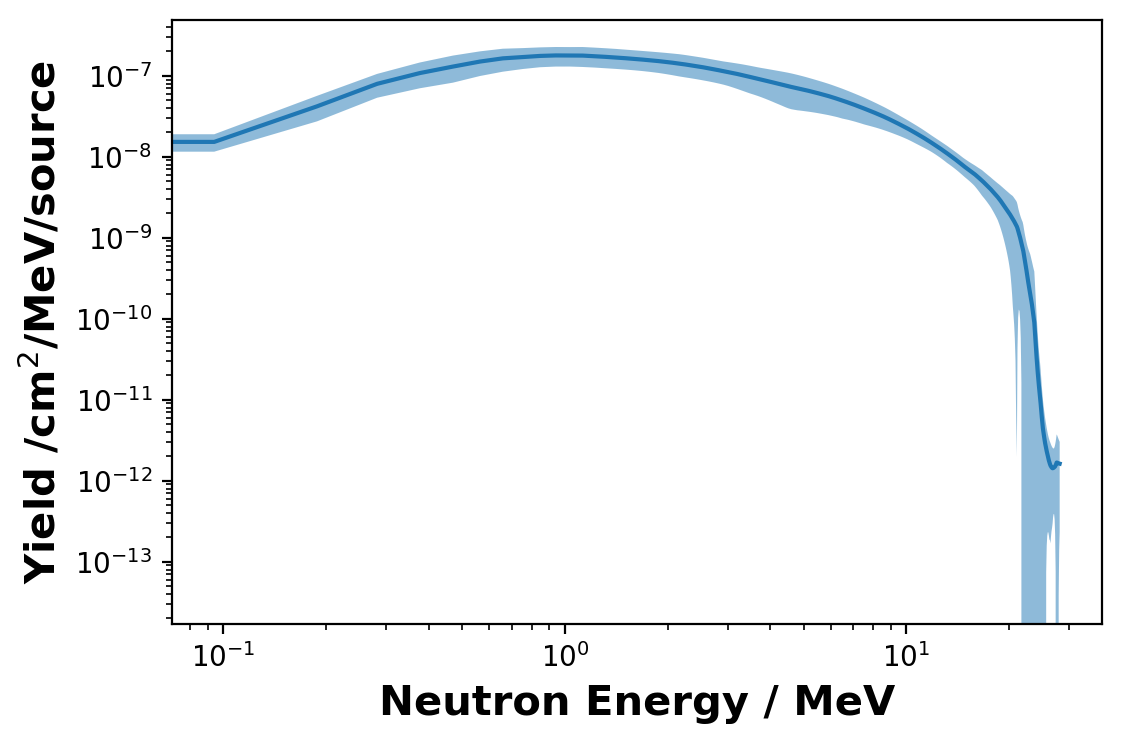

In [8]:
x= np.linspace(0,150,300)
x_in = san_input(En=x, Ep=30, dL=105, Theta=90, Proj=0, Conv='000', display_output=True)
En , Ec = estimate_cutoff(x_in)
x= np.linspace(0,Ec,300)
x_in = san_input(En=x, Ep=30, dL=105, Theta=90, Proj=0, Conv='000', display_output=True)

x_out = calc_spectrum(x_in, uncertainty=True)
# plot data
plt.figure(dpi=200)
plt.plot(x_out[:,0]*150,x_out[:,8])
# calc error
plt.fill_between(x, x_out[:,8]-2*x_out[:,9], x_out[:,8]+2*x_out[:,9], alpha=0.5)

plt.ylabel(r'Yield /cm$^2$/MeV/source', fontsize = 15, weight='bold' );
plt.xscale('log')

plt.xlabel('Neutron Energy / MeV', fontsize = 15, weight='bold' );
plt.yscale('log')

#plt.savefig("taccWaterPosition.pdf")



Converter Lengh:
105
Scattering Angle Used:
90
Identified Proton Projectile.
Target identified as: li
Projectile Energy:
30
Cut-off energy is 0.2812 or 28.12 MeV
Converter Lengh:
105
Scattering Angle Used:
90
Identified Proton Projectile.
Target identified as: li
Projectile Energy:
30
Spectrum suddessfully generated; 300 samples generated.


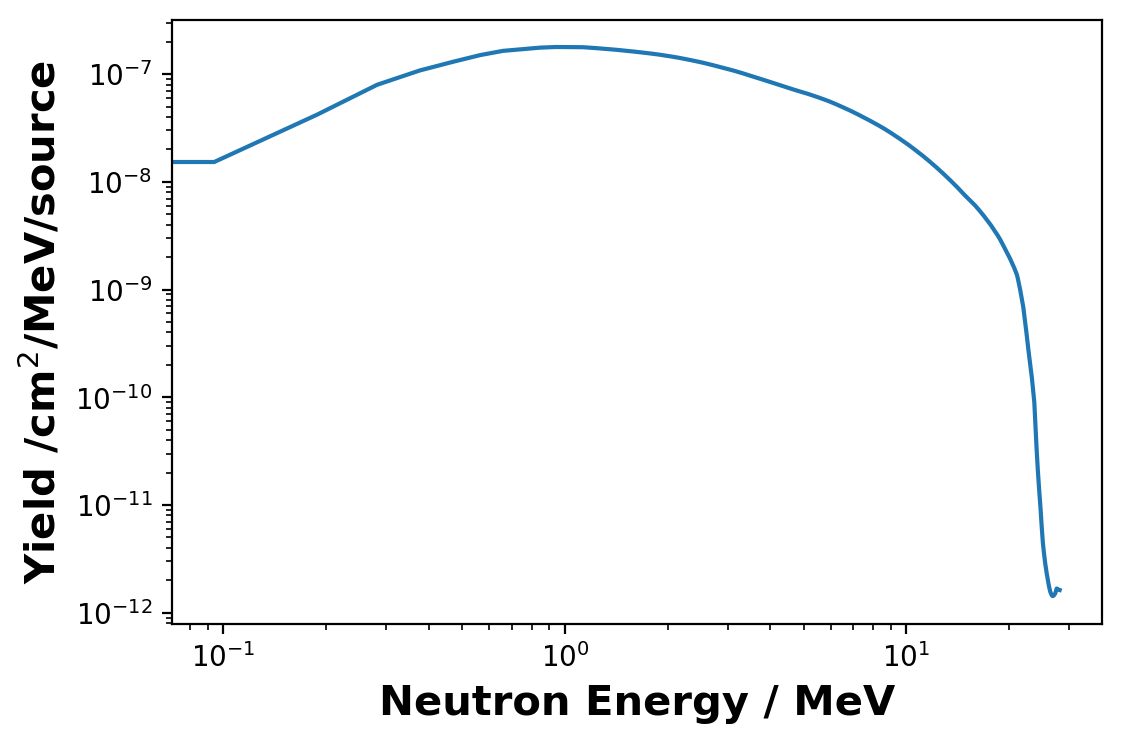

In [9]:
x= np.linspace(0,150,300)
x_in = san_input(En=x, Ep=30, dL=105, Theta=90, Proj=0, Conv='000', display_output=True)
En , Ec = estimate_cutoff(x_in)
x= np.linspace(0,Ec,300)
x_in = san_input(En=x, Ep=30, dL=105, Theta=90, Proj=0, Conv='000', display_output=True)

x_out = calc_spectrum(x_in)
# plot data
plt.figure(dpi=200)
plt.plot(x_out[:,0]*150,x_out[:,8])

plt.ylabel(r'Yield /cm$^2$/MeV/source', fontsize = 15, weight='bold' );
plt.xscale('log')

plt.xlabel('Neutron Energy / MeV', fontsize = 15, weight='bold' );
plt.yscale('log')

#plt.savefig("taccWaterPosition.pdf")



## Beam models

In [11]:
import pickle
with open('validcurves.pkl', 'rb') as f:
    ValidData = pickle.load(f)

ValidLabels = list(ValidData.keys())


## Adjust Data for different detector sizes:
AngletoAreas = np.array([#
[2.5, 14.94],
[ 7.5, 44.72],
[ 12.5, 74.15], 
[ 20.0, 234.12], 
[ 30.0, 342.26], 
[ 40.0, 440.00], 
[ 50.0, 524.37], 
[ 60.0, 592.81], 
[ 70.0, 643.24], 
[ 80.0, 674.12], 
[ 90.0, 684.52], 
[ 100.0, 674.12], 
[ 110.0, 643.24], 
[ 120.0, 592.81],  
[ 130.0, 524.37], 
[ 140.0, 440.00], 
[ 150.0, 342.26], 
[ 160.0, 234.12], 
[ 167.5, 74.15], 
[ 172.5, 44.72], 
[ 177.5, 14.94 ]])

AngletoAreas[AngletoAreas[:,0]==2.5][0][1]


14.94

In [12]:
# Projectile OHE, Target OHE
# Energy in MeV, TargetThickness in mm, Curren in A
Conventional_dict = {#'IAEA_1':{'Projectile':0, 'Target':'000', 'Energy':40,'DeltaEnergy':0.0, 'TargetThickness': 20, 'Current':5E-3},
                     'IAEA_2':{'Projectile':0, 'Target':'010', 'Energy':40,'DeltaEnergy':0.0, 'TargetThickness': 20, 'Current':5E-3},
                     #'IAEA_3':{'Projectile':0, 'Target':'000', 'Energy':40,'DeltaEnergy':0.0, 'TargetThickness': 20, 'Current':125E-3},
                     'IAEA_4':{'Projectile':0, 'Target':'010', 'Energy':40,'DeltaEnergy':0.0, 'TargetThickness': 20, 'Current':125E-3},
                     #'IAEA_5':{'Projectile':1, 'Target':'000', 'Energy':40,'DeltaEnergy':0.0, 'TargetThickness':  6, 'Current':5E-3},
                     #'IAEA_6':{'Projectile':1, 'Target':'010', 'Energy':40,'DeltaEnergy':0.0, 'TargetThickness':  6, 'Current':5E-3},
                     #'IAEA_7':{'Projectile':1, 'Target':'000', 'Energy':40,'DeltaEnergy':0.0, 'TargetThickness':  6, 'Current':125E-3},
                     #'IAEA_8':{'Projectile':1, 'Target':'010', 'Energy':40,'DeltaEnergy':0.0, 'TargetThickness':  6, 'Current':125E-3},
                     'RIKEN_RANS':{'Projectile':0, 'Target':'010', 'Energy':7,'DeltaEnergy':0.0, 'TargetThickness':  0.3, 'Current':1E-4},
                     'HBS':{'Projectile':0, 'Target':'010', 'Energy':70,'DeltaEnergy':0.0, 'TargetThickness':  16, 'Current':1E-1},
                     'SONATE':{'Projectile':0, 'Target':'010', 'Energy':20,'DeltaEnergy':0.0, 'TargetThickness':  2, 'Current':1E-1},
                    }
# Get the indicators to loop over. 
Conventional_machines = list(Conventional_dict.keys())
# The angles to be taken into account:
Angles = [  0. ,   7.5,  12.5,  20. ,  30. ,  40. ,  50. ,  60. ,  70. ,
        80. ,  90. , 100. , 110. , 120. , 130. , 140. , 150. , 160. ,
       167.5, 172.5, 180. ]#[0,15,30,45,60,75,90,105,120,135,150,165]

In [13]:
# Calculate the maximum neutron cutoff energy to be expected as MaxEnergy
for key in Conventional_machines:
    # loop over all machines
    temp = Conventional_dict[key]
    if temp['Projectile'] == 0:
        MaxEnergy = temp['Energy'] + ProtonQValue[temp['Target']]
    elif temp['Projectile'] == 1:
        MaxEnergy = temp['Energy'] + DeuterQValue[temp['Target']]
    Conventional_dict[key]['MaxEnergy'] = MaxEnergy

    # Get maximum Neutron energy!
    En_max = temp['MaxEnergy']
    # Create log/lin combined mesh
    Enmesh_log = np.logspace(np.log10(1E-4), np.log10(En_max), num=100)
    Enmesh_lin = np.linspace(1E-4, En_max, num=100)
    Enmesh = np.concatenate((Enmesh_log, Enmesh_lin))
    x_in_list = []
    for theta in Angles:
        # loop over te angles
        # sanitize model inputs
        x_in_list.append(san_input(En=Enmesh, Ep=temp['Energy'], dL=temp['TargetThickness'], 
                                   Theta=theta/180, Proj=temp['Projectile'], Conv=temp['Target'], 
                                   display_output=False)
                        )
    # concatenate final arrays:
    x_in = np.vstack((x_in_list))
        

In [14]:
# Loop over the model and create a dataarray with all parameters: 
# x_in[:,0] = En[i]           /150 # neutron energy bin
# x_in[:,1] = Ep              /100 # projectile energy
# x_in[:,2] = dL              /105 # length
# x_in[:,3] = TempTheta       /180 # angle
# x_in[:,4] = TempProj             # OHE P
# x_in[:,5] = int(TempConv[0])     # OHE T1
# x_in[:,6] = int(TempConv[1])     # OHE T2
# x_in[:,7] = int(TempConv[2])     # OHE T3
# empty list!
x_in_list = []
for key in tqdm.tqdm(Conventional_machines):
    # loop over all machines
    TEMP = Conventional_dict[key]

    # Get maximum Neutron energy!
    En_max = TEMP['MaxEnergy']
    # Create log/lin combined mesh
    Enmesh_log = np.logspace(np.log10(1E-4), np.log10(En_max), num=100)
    Enmesh_lin = np.linspace(1E-4, En_max, num=100)
    Enmesh = np.concatenate((Enmesh_log, Enmesh_lin))
    x_in_list=[]
    for theta in Angles:
        # loop over te angles
        # sanitize model inputs
        x_in_list.append(san_input(En=Enmesh, Ep=TEMP['Energy'], dL=TEMP['TargetThickness'], 
                                   Theta=theta, Proj=TEMP['Projectile'], Conv=TEMP['Target'], 
                                   display_output=False
                                  )
                        )
    # concatenate final arrays:
    x_in = np.vstack((x_in_list))
    x_out = calc_spectrum(x_in=x_in,uncertainty=True)
    Conventional_dict[key]['data'] = x_out

 20%|██        | 1/5 [00:00<00:00,  4.10it/s]

Spectrum suddessfully generated; 4200 samples generated.


 40%|████      | 2/5 [00:00<00:00,  4.16it/s]

Spectrum suddessfully generated; 4200 samples generated.


 60%|██████    | 3/5 [00:00<00:00,  4.22it/s]

Spectrum suddessfully generated; 4200 samples generated.


 80%|████████  | 4/5 [00:00<00:00,  4.15it/s]

Spectrum suddessfully generated; 4200 samples generated.


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]

Spectrum suddessfully generated; 4200 samples generated.


Cut-off energy is 0.22030000000000002 or 22.03 MeV
Spectrum suddessfully generated; 6000 samples generated.
Cut-off energy is 0.6003000000000001 or 60.03 MeV
Spectrum suddessfully generated; 6000 samples generated.
Cut-off energy is 1.0003 or 100.03 MeV
Spectrum suddessfully generated; 6000 samples generated.
Cut-off energy is 0.22030000000000002 or 22.03 MeV
Spectrum suddessfully generated; 6000 samples generated.
Cut-off energy is 0.6003000000000001 or 60.03 MeV
Spectrum suddessfully generated; 6000 samples generated.
Cut-off energy is 1.0003 or 100.03 MeV
Spectrum suddessfully generated; 6000 samples generated.
Cut-off energy is 0.1136 or 11.360000000000001 MeV
Spectrum suddessfully generated; 6000 samples generated.
Cut-off energy is 0.4936 or 49.36 MeV
Spectrum suddessfully generated; 6000 samples generated.
Cut-off energy is 0.8936 or 89.36 MeV
Spectrum suddessfully generated; 6000 samples generated.
Cut-off energy is 0.1136 or 11.360000000000001 MeV
Spectrum suddessfully generat

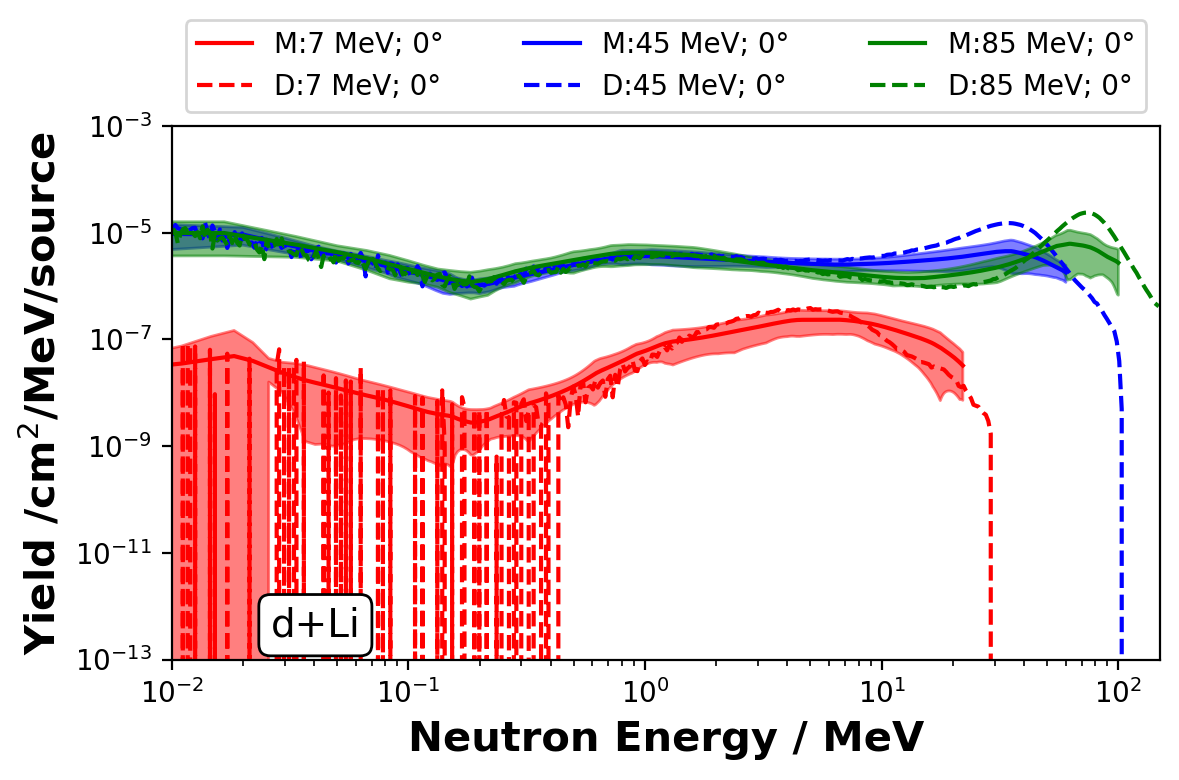

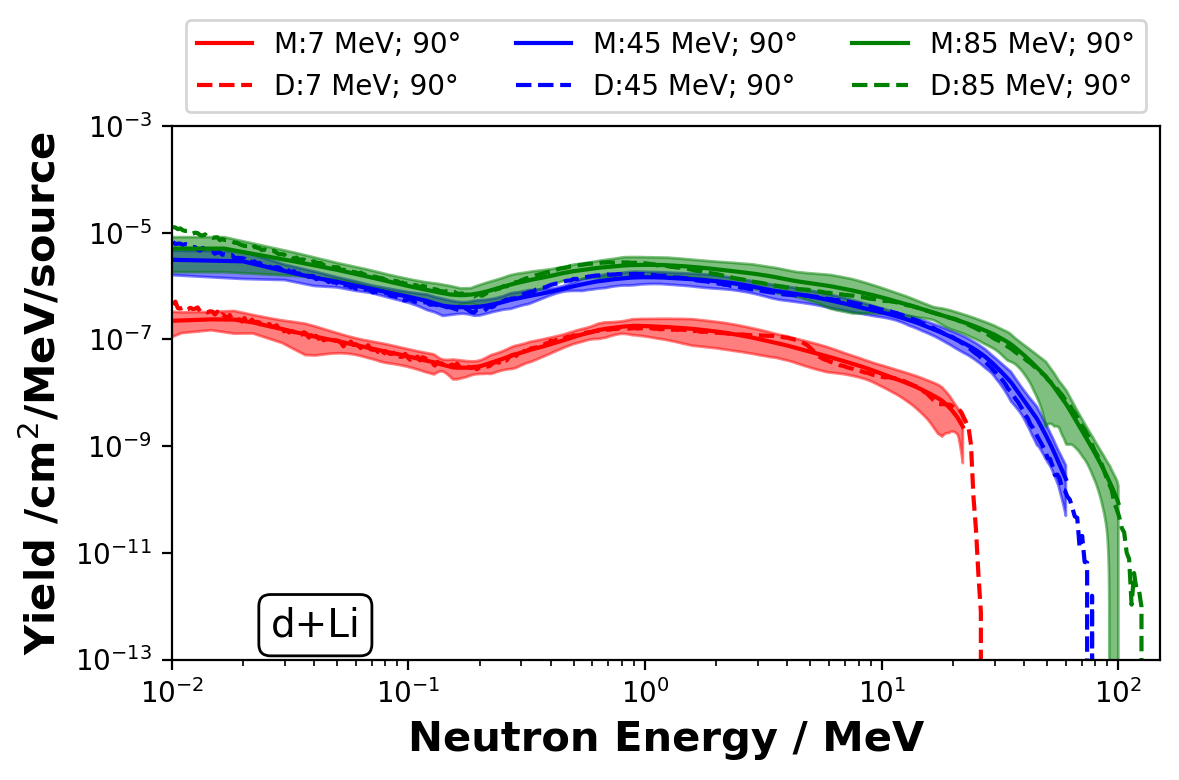

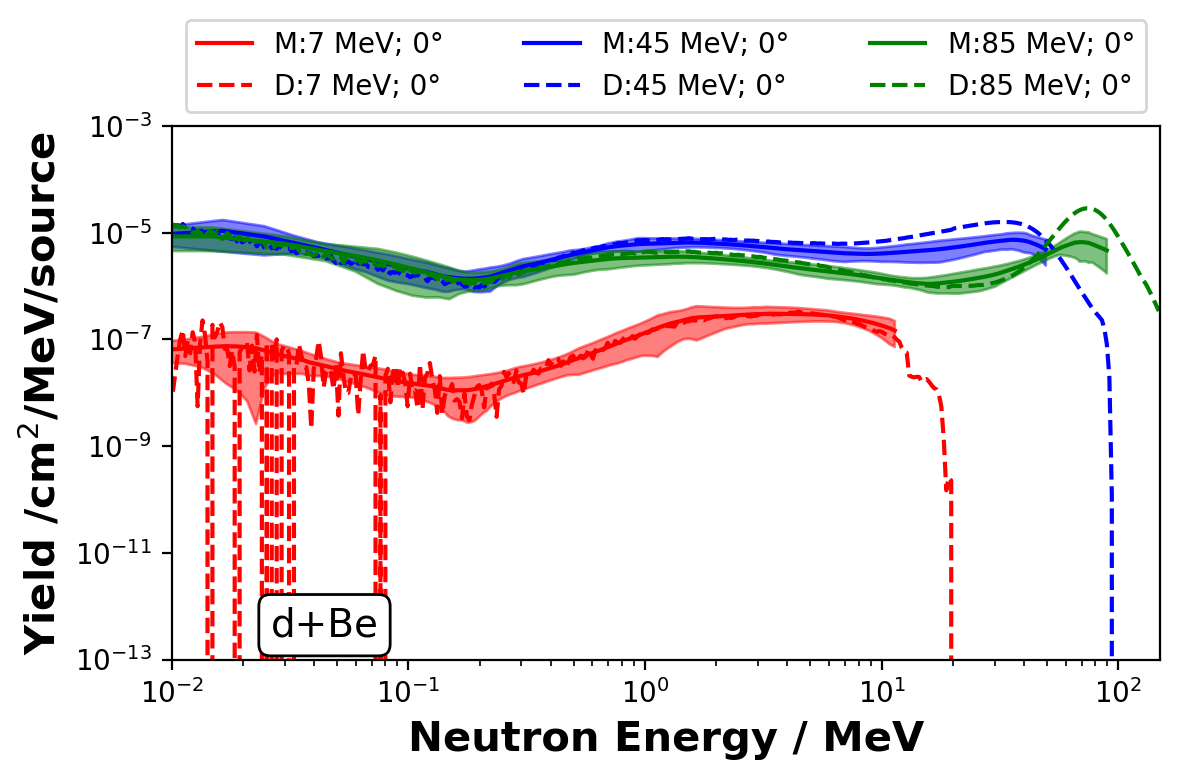

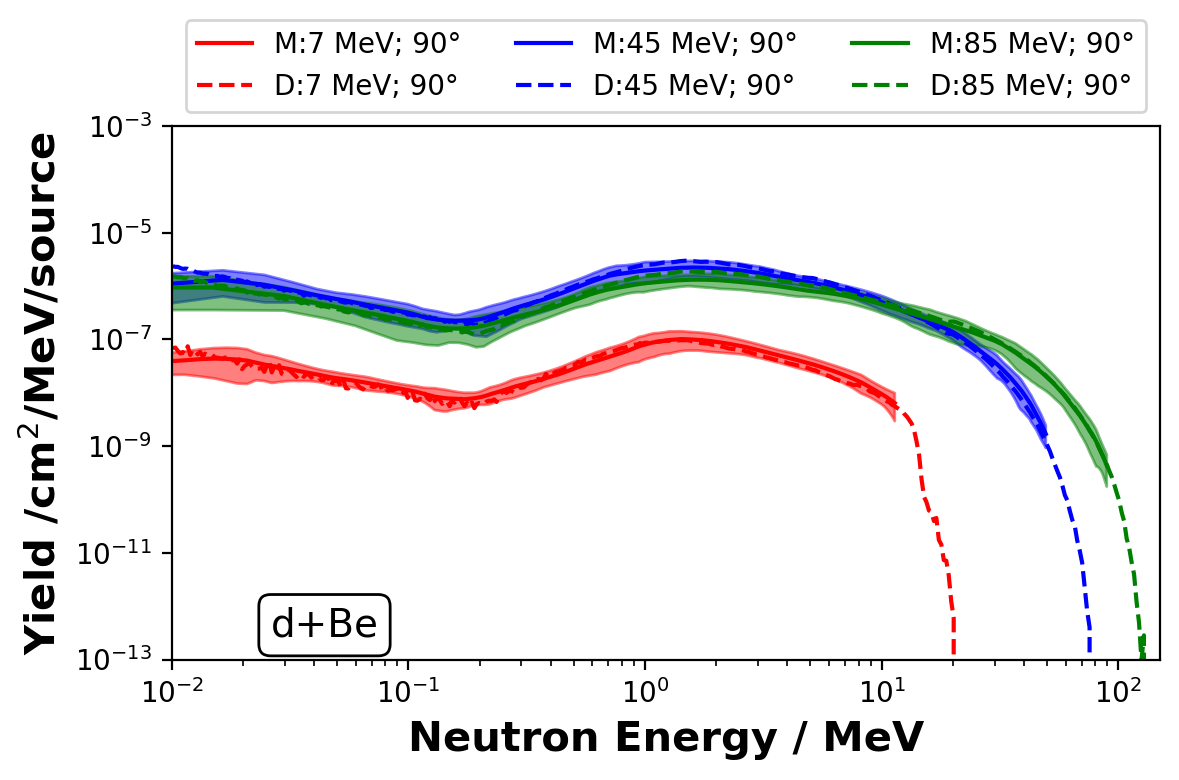

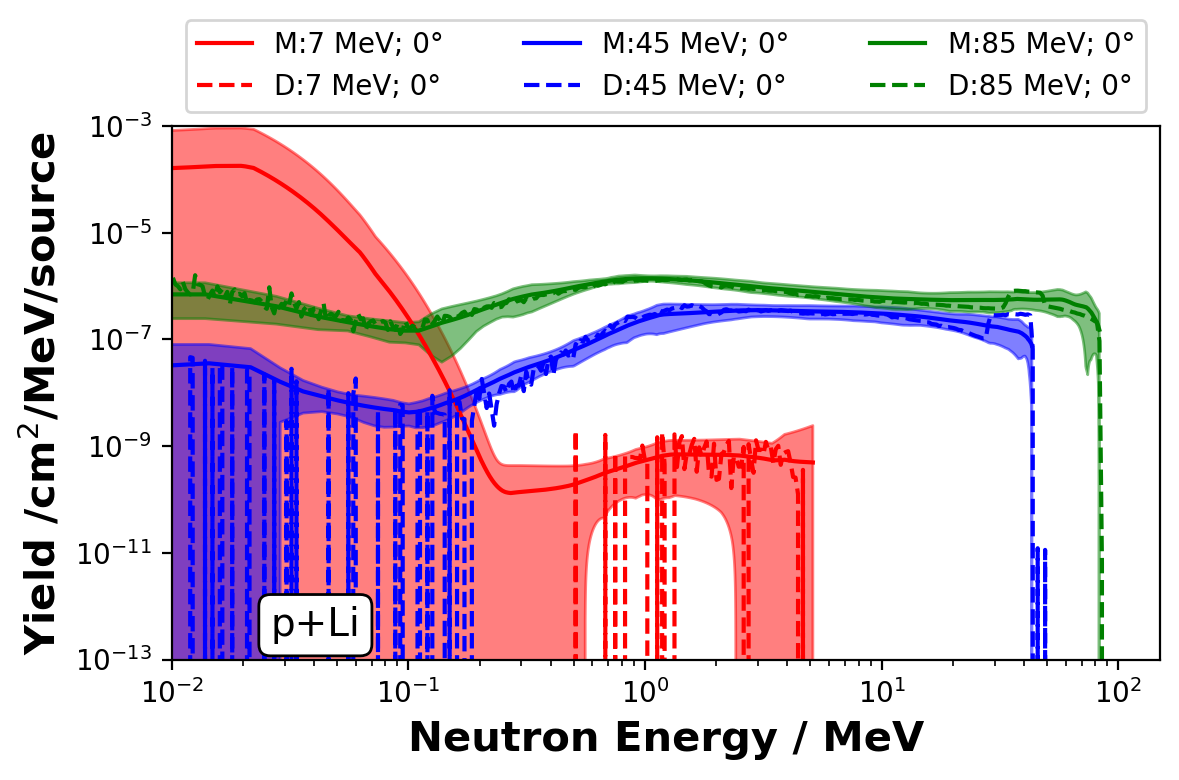

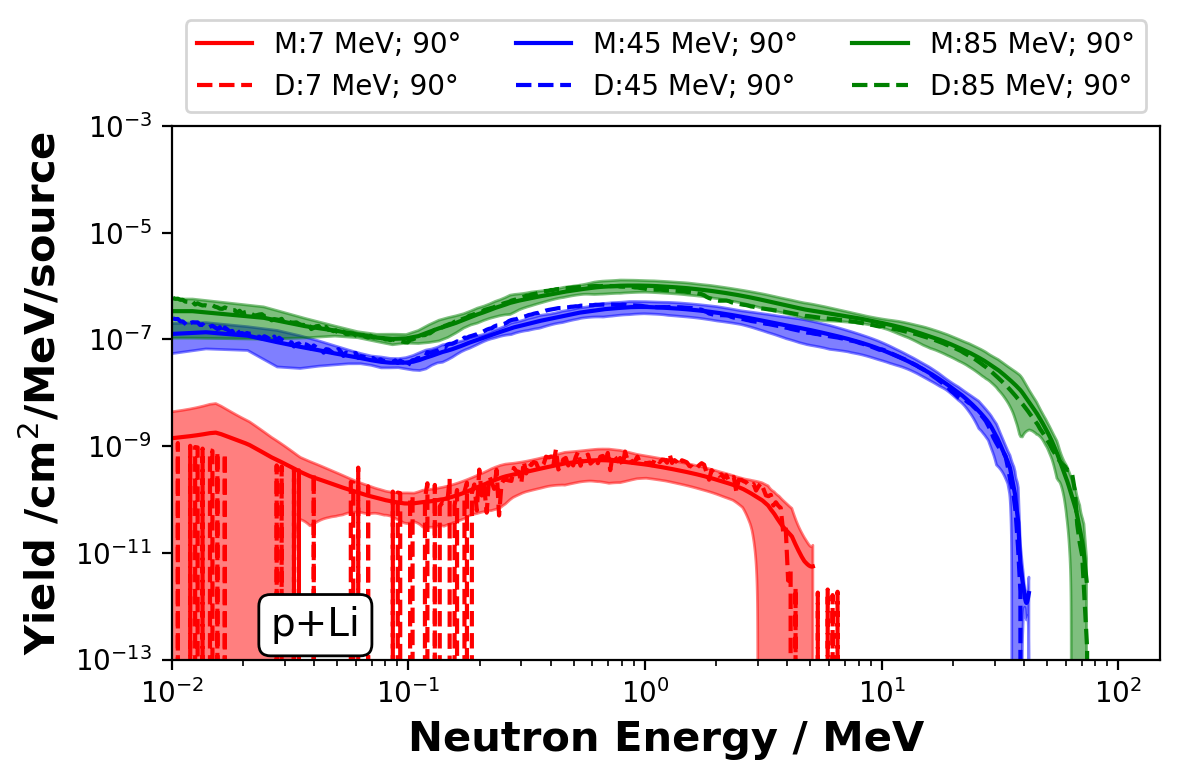

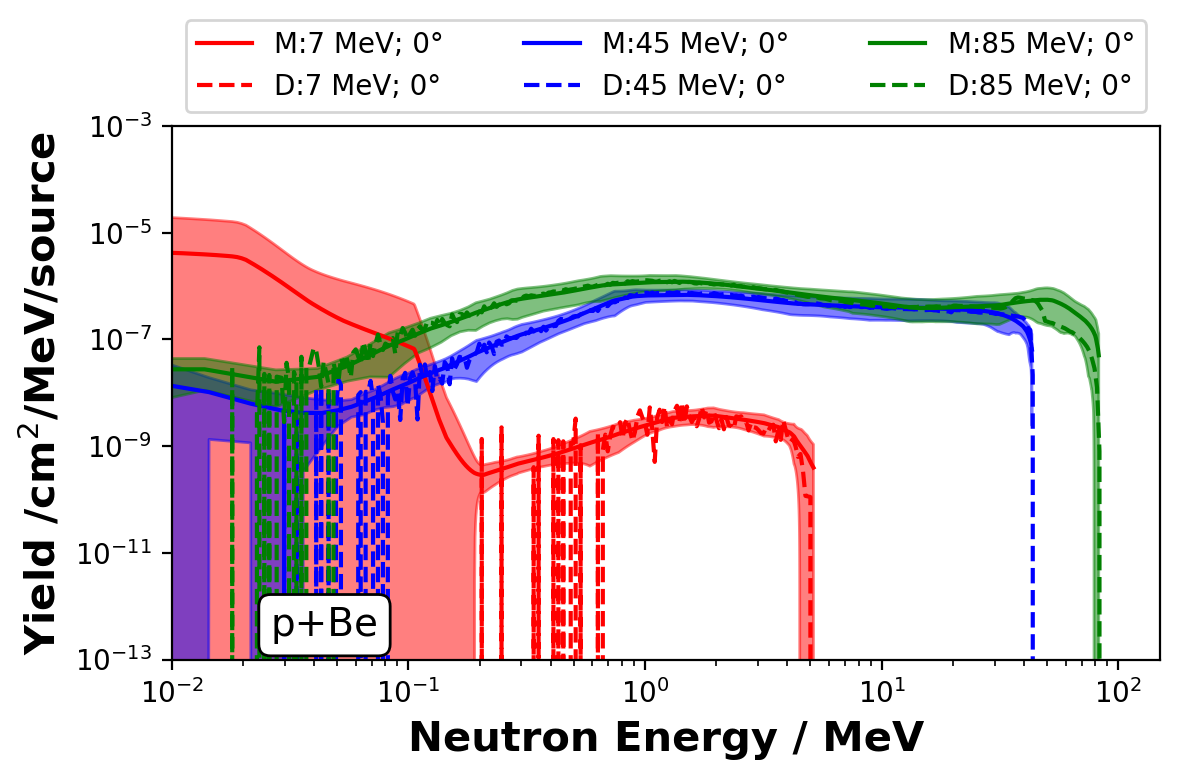

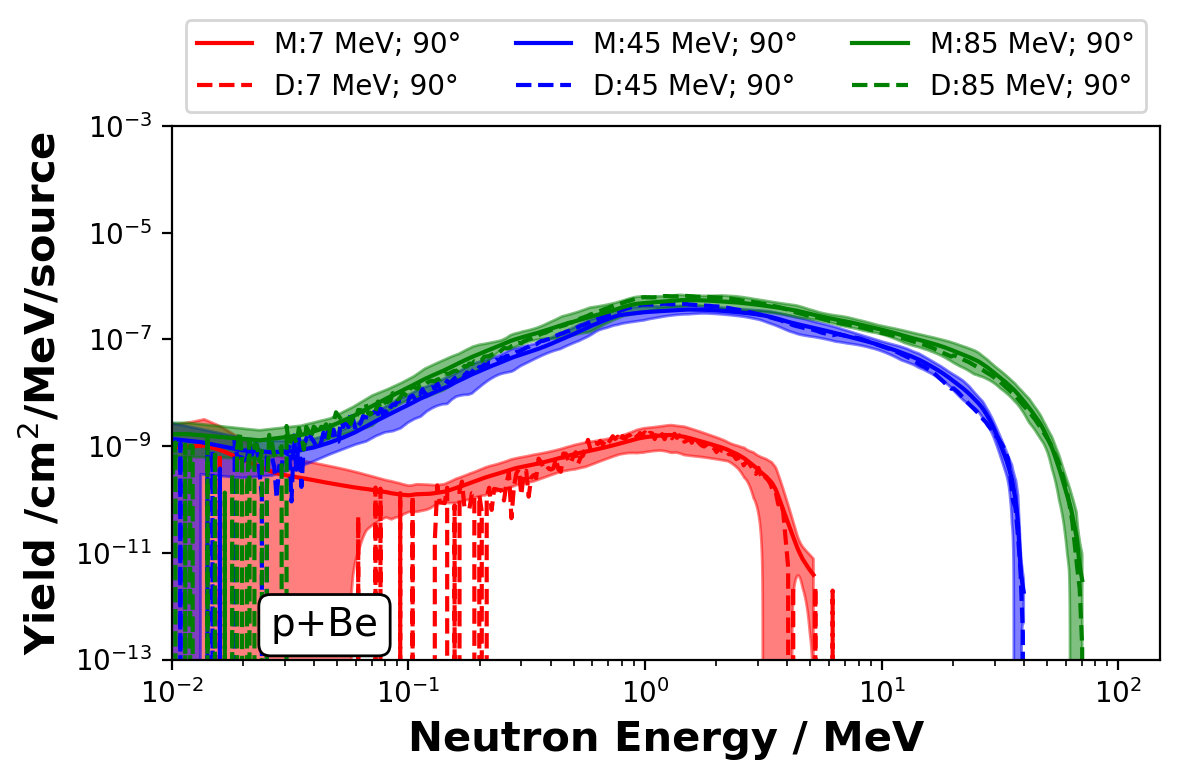

In [15]:
#colorlist
cl = ['r','b','g','c','m','y','k']
props = dict(boxstyle='round', facecolor='white')

for n in range(4):
    for m in ['2.5','90']:
        f, ax = plt.subplots(dpi=200)
        # counter for the color range:
        j=0
        for item in ValidLabels[n*6:(n+1)*6]:
            temp = item.split('_')
            # Only work on theta degree!
            if temp[3] == m:

                x= np.linspace(0,150,300)
                x_in = san_input(En=x, Ep=float(temp[2]), dL=float(temp[4]), Theta=float(temp[3]), 
                                 Proj=temp[0], Conv=temp[1], display_output=False)
                En , Ec = estimate_cutoff(x_in)
                x= np.linspace(0,Ec,6000)
                x_in = san_input(En=x, Ep=float(temp[2]), dL=float(temp[4]), Theta=float(temp[3]), 
                                 Proj=temp[0], Conv=temp[1], display_output=False)

                x_out = calc_spectrum(x_in)
                
                # plot model data
                if m== '2.5':
                    mout = '0'
                else:
                    mout = m
                
                plt.plot(x_out[:,0]*150,x_out[:,8],cl[j], label='M:'+temp[2]+' MeV; '+mout+'°')
                plt.fill_between(x_out[:,0]*150, (x_out[:,8]-2*x_out[:,9]),(x_out[:,8]+2*x_out[:,9]),color=cl[j], alpha=0.5)
                #plt.plot(x_out[:,0]*150,x_out[:,8], label='M:'+temp[2]+' MeV; '+mout+'°')

                x_MC = ValidData[item][0]
                y_MC = ValidData[item][1]
                # correct the Monte Carlo spectra with the correct detetor surface
                correction = AngletoAreas[AngletoAreas[:,0]==float(m)][0][1]
                plt.plot(x_MC,y_MC/correction,'--',color=cl[j], label='D:'+temp[2]+' MeV; '+mout+'°')
                
                j=j+1
                
        ax.text(0.1,0.1, r''+temp[0][0]+'+'+temp[1], size=50,#transform=ax.transAxes, #transform=ax.transAxes, 
                fontsize=14, ha='left', va='top', transform=ax.transAxes,bbox=props)#;6transform=ax.transAxes

        plt.ylabel(r'Yield /cm$^2$/MeV/source', fontsize = 15, weight='bold' );
        plt.xscale('log')

        plt.xlabel('Neutron Energy / MeV', fontsize = 15, weight='bold' );
        plt.yscale('log')

        plt.xlim([1E-2,150])
        plt.ylim([1E-13,1E-3])
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3)
        plt.tight_layout()
        plt.savefig(temp[0]+'+'+temp[1]+'+'+m+".pdf")


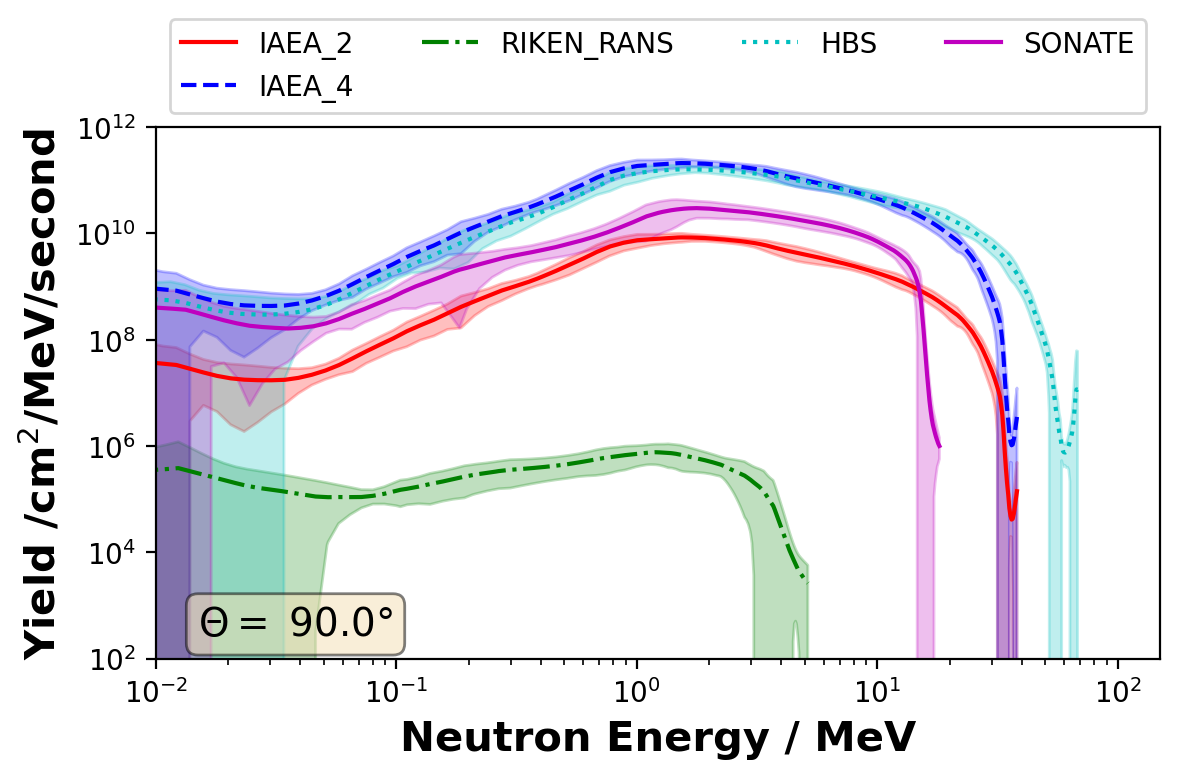

In [16]:
cl = ['r','b','g','c','m','y','k']
props = dict(boxstyle='round', facecolor='white')
CurrentCorrection = True
# plot 2d spectra 
theta = Angles[10]
List_of_Machines = Conventional_machines

fig = plt.figure(dpi=200)

n=0
for machine in Conventional_machines:
    # Include the Current:
    if CurrentCorrection: CurrentCorr = Conventional_dict[machine]['Current']*6.242E18
    else: CurrentCorr=1
    plotting = Conventional_dict[machine]['data']
    plotting = plotting[plotting[:,3]==theta/180]
    plotting= plotting[plotting[:, 0].argsort()]
    plt.plot(plotting[:,0]*150,plotting[:,-2]*CurrentCorr, lines[n], color = cl[n], label=machine)
    plt.fill_between(plotting[:,0]*150, (plotting[:,-2]-2*plotting[:,-1])*CurrentCorr, (plotting[:,-2]+2*plotting[:,-1])*CurrentCorr, color = cl[n], alpha=0.25)
    
    n=n+1
    
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4)
if CurrentCorrection: plt.ylabel(r'Yield /cm$^2$/MeV/second', fontsize = 15, weight='bold' );
else: plt.ylabel(r'Yield /cm$^2$/MeV/source', fontsize = 15, weight='bold' );
plt.xscale('log')

plt.xlabel('Neutron Energy / MeV', fontsize = 15, weight='bold' );
plt.yscale('log')
plt.xlim([1E-2,150])
plt.ylim([1E2, 1E12])

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(1E-2*1.5,1E2*10, r'$\Theta=$ '+str(theta)+'°', size=50,#transform=ax.transAxes, #transform=ax.transAxes, 
         fontsize=14, verticalalignment='top',bbox=props);#6transform=ax.transAxes

plt.tight_layout()

#plt.savefig('conventional_'+'proton'+'_'+'beryllium'+'_'+str(theta)+'.pdf')

In [42]:
# function to interpolate data bins from the analytical form: 
## d𝑁/d𝐸 = 𝑁_0 𝐸 exp(−𝐸/𝑘_B 𝑇)

def construc_spectrum(N0,kBT,E_bound, model_select='standard'):
    """
    Function to define the analytical representation of a TNSA bunch. 

    Parameters
    ----------
    N0 : float 64
        Number indicator for the exponential function.
    kBT : float 64
        Decay rate for the particle spectrum in MeV .
    E_bound : tuple float 64
        Two element tuple, definining (E_min, E_max) in MeV.
    model_select : str 
        Select the analytical TNSA model.
    
    Returns
    -------
    f : function
        Defined spectrum with attributes:
        f.N0 = N0
        f.kBT = kBT
        f.Emin = E_bound[0]
        f.Emax = E_bound[1]        
        
    """
    def f(E):    
        
        if E < E_bound[0]: return 0.
        elif E <= E_bound[1]:
            if model_select == 'standard':
                # pure spectrum
                label = 'a/E * exp(-E/b) * H(-E + c)'
                return N0 / E * np.exp(-E / kBT)
                
            elif model_select == 'fuchs':
                label = '(a/sqrt(2*E/b)) * exp(-sqrt(2E/b)) * H(-E + c)'
                doi = 'https://doi.org/10.1038/nphys199'
                return N0/np.sqrt(2*E*kBT)*np.exp(-np.sqrt(2*E/kBT))

            elif model_select == 'quad':
                label = 'a/E * exp(-E**2 / b**2) * H(-E + c)'
                return N0 / E * np.exp(-E**2 / kBT**2)
                
            else: 
                print('Unknown model detected!')
        
        else: return 0.
    # define additional parameters for f
    if model_select == 'standard':
        # pure spectrum
        label = 'a/E * exp(-E/b) * H(-E + c)'
                
    elif model_select == 'fuchs':
        label = '(a/sqrt(2*E/b)) * exp(-sqrt(2E/b)) * H(-E + c)'
        doi = 'https://doi.org/10.1038/nphys199'

    elif model_select == 'quad':
        label = 'a/E * exp(-E**2 / b**2) * H(-E + c)'
                
    else: 
        print('Unknown model detected!')
    
    f.N0 = N0
    f.kBT = kBT
    f.Emin = E_bound[0]
    f.Emax = E_bound[1]
    if 'label' in locals():
        f.label = label
    if 'doi' in locals():
        f.doi = doi

    return f

# sampling: If the spectral parameters are obtained using pyRES, 
# then the data is binned with a binning width of 1 MeV.
# I therefore recommend to keep the binning for neutron calculation input in the same width.
# Otherwise a rebinning has to be done. 
# For the neuron estimation the energy and the countrate is needed. So a two line array:


def generate_sampling(spectrum, E_bound_sampling):
    # step 1: sanitize model range
    if spectrum.Emin > E_bound_sampling[0]:
        sampling_min = spectrum.Emin
    else: 
        sampling_min = E_bound_sampling[0]
    if spectrum.Emax < E_bound_sampling[1]:
        sampling_max = spectrum.Emax
    else: 
        sampling_max = E_bound_sampling[1]
        
    # step 2: identify the "sampleable" range and get the numver of sample steps
    No_Steps = np.floor(sampling_max-sampling_min)
    # counting backwards, since higher energies are more important than lower ones:
    Energy = []
    Counts = []
    for i in range(int(No_Steps)):
        Energy.append(spectrum.Emax-i)
        Counts.append(spectrum(spec.Emax-i))
        
    return np.array((Energy,Counts))

def prepare_plot_data_TNSA(TNSA_object, theta):
#if True:
    # spectrum extracted and normalized!
    spectral = TNSA_object['spectrum']
    # check whether the data set has an error column
    # this is true if the second axis has 10 rows!
    datashape = TNSA_object['data'].shape
    #select data by angle to be displayed
    plotData = TNSA_object['data'][:,[0,1,3,8]]
    sigma = np.zeros((datashape[0],1))
    # overwrite sigma = 0 if the error exists
    if datashape[1] == 10: 
        sigma = TNSA_object['data'][:,9:10]
    # stitch sigma and the data together
    plotData = np.hstack((plotData,sigma))
   # plotData = np.hstack((plotData,sigma))

    #select only the values wih the relevant angle
    plotData = plotData[plotData[:,2]==theta/180]
    # overwrite the angle value (since it is only one now) with the current correction
    for i in range(spectral.shape[1]):
        # select all bins for the same projectile energy, and add the currentfactor
        ind = plotData[:,1]==spectral[0,i]/100
        # write current down 
        plotData[ind,2] = spectral[1,i]
    # sum up 
    energy_bins = list(set(plotData[:,0]))
    plot = np.zeros((len(energy_bins),3))
    n=0
    for En in energy_bins:
        #select all energy bins and add them up weighted with the number of 
        #incoming particles
        temp = plotData[plotData[:,0]==En]
        data = np.sum(temp[:,3]*temp[:,2])
        error = np.sqrt(np.sum(temp[:,4]**2 *temp[:,2]**2))
        plot[n,:] = [En,data,error]
        n=n+1
    
    return plot

def integrate_energy_TNSA(TNSA_object, theta, bounds='None'):
    # Step 1 Order Data
    # spectrum extracted and normalized!
    spectral = TNSA_object['spectrum']
    #select data by angle to be displayed
    plotData = TNSA_object['data'][:,[0,1,3,8,9]]
    plotData = plotData[plotData[:,2]==theta/180]
    # overwrite the angle value (since it is only one now) with the current correction
    for i in range(spectral.shape[1]):
        # select all bins for the same projectile energy, and add the currentfactor
        ind = plotData[:,1]==spectral[0,i]/100
        # write current down 
        plotData[ind,2] = spectral[1,i]
    # sum up 
    energy_bins = list(set(plotData[:,0]))
    plot = np.zeros((len(energy_bins),3))
    n=0
    for En in energy_bins:
        #select all energy bins and add them up weighted with the number of incoming particles
        temp = plotData[plotData[:,0]==En]
        data = np.sum(temp[:,3]*temp[:,2])
        sigma = np.sqrt(np.sum(temp[:,2]*temp[:,4]**2))
        plot[n,:] = [En,data,sigma]
        n=n+1
    # Step 2 Apply cubic spline
    from scipy import interpolate
    x = np.array(plot)
    x_sorted = x[x[:, 0].argsort()]
    
    #fnc = interpolate.CubicSpline(x = x_sorted[:,0], y = x_sorted[:,1])
    fnc_mean  = interpolate.CubicSpline(x = x_sorted[:,0], y = x_sorted[:,1])
    fnc_plus  = interpolate.CubicSpline(x = x_sorted[:,0], y = (x_sorted[:,1]+2*x_sorted[:,2]))
    fnc_minus = interpolate.CubicSpline(x = x_sorted[:,0], y = (x_sorted[:,1]-2*x_sorted[:,2]))
    
    # Step 3 integrate spline
    if bounds=='None':
        a = min(x_sorted[:,0])
        b = max(x_sorted[:,0])
    else:
        a = bounds[0]
        b = bounds[1]
        
    value_mean = fnc_mean.integrate(a, b)
    value_plus = fnc_plus.integrate(a, b)
    value_minus = fnc_minus.integrate(a, b)
    
    return [theta, value_mean, value_minus, value_plus]


In [44]:
TNSA_dict = {'LIGHT':{'Projectile':0, 'RepRate':1/5400.,'N0':3.7E11,'kBT':7.4,
                       'Ebound':(5,25.5), 
                       #'Ebound':(2,22.6), 
                       'Target':'010', 'TargetThickness': 5.02},
            }
# TNSA:
TNSA_Setups = list(TNSA_dict.keys())

# Calculate the maximum neutron cutoff energy to be expected as MaxEnergy
for key in tqdm.tqdm(TNSA_Setups):
    TEMP = TNSA_dict[key]
    # step 1: calculate the defined TNSA spectrum 
    # only if it does not already exist
    if TEMP['N0'] != 'NaN' and TEMP['kBT'] != 'NaN':
        # {'Projectile':0, 'N0':1E21,'kBT':3,'Ebound':(2,30) 'Target':'000', 'TargetThickness': 20}
        spec = construc_spectrum(N0=TEMP['N0'],kBT=TEMP['kBT'],E_bound=TEMP['Ebound'],model_select='standard')
        samples = generate_sampling(spectrum=spec, E_bound_sampling=TEMP['Ebound'])
        TNSA_dict[key]['spectrum'] = samples
        
    else: 
        samples = TNSA_dict[key]['spectrum']
        samples = samples[:, samples[0] > 1.85]
    
    # define the qvalue needed for energy correction!
    if TEMP['Projectile'] == 0:
        QValue = ProtonQValue[TEMP['Target']]
    elif TEMP['Projectile'] == 1:
        QValue = DeuterQValue[TEMP['Target']]
    TNSA_dict[key]['QValue'] = QValue
    
    #preallocate an empty array:
    #Array_En = np.zeros((samples.shape[1],3))
    # we take the approach over a global energie mesh.
    # to do this we create a maximum mesh and fill it accordingly.
    MaximumMesh = np.max(samples[0,:])+QValue
    # Create log/lin combined mesh
    Enmesh_log = np.logspace(np.log10(1E-4), np.log10(MaximumMesh), num=500)
    Enmesh_lin = np.linspace(1E-4, MaximumMesh, num=500)
    Enmesh = np.concatenate((Enmesh_log, Enmesh_lin))
    
    # allocate empty list for the input variables:
    x_in_list = []
    # loop over all energies
    
    for i in range(samples.shape[1]):
        samp = samples[:,i]
        #print(samp[0])

        # Get maximum Neutron energy for this bin:
        En_max = samp[0]+TEMP['QValue']
        # reduced mesh:
        tempEnmesh = Enmesh[Enmesh<=En_max]    
        # loop over all relevant angles.
        for theta in Angles:
            # loop over the angles
            # sanitize model inputs
            x_in_list.append(san_input(En=tempEnmesh, Ep=samp[0], dL=TEMP['TargetThickness'], 
                                       Theta=theta, Proj=TEMP['Projectile'], Conv=TEMP['Target'], 
                                       display_output=False)
                            )
    # concatenate final arrays:
    x_in = np.vstack((x_in_list))
    # apply the prediction
    x_out = calc_spectrum(x_in=x_in)
    TNSA_dict[key]['data'] = x_out

100%|██████████| 1/1 [00:14<00:00, 14.07s/it]

Spectrum suddessfully generated; 325017 samples generated.


In [88]:
#TNSA_dict['MULTI_Emax']['spectrum']

In [ ]:
[Angles[x] for x in[0,5,10]]

100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


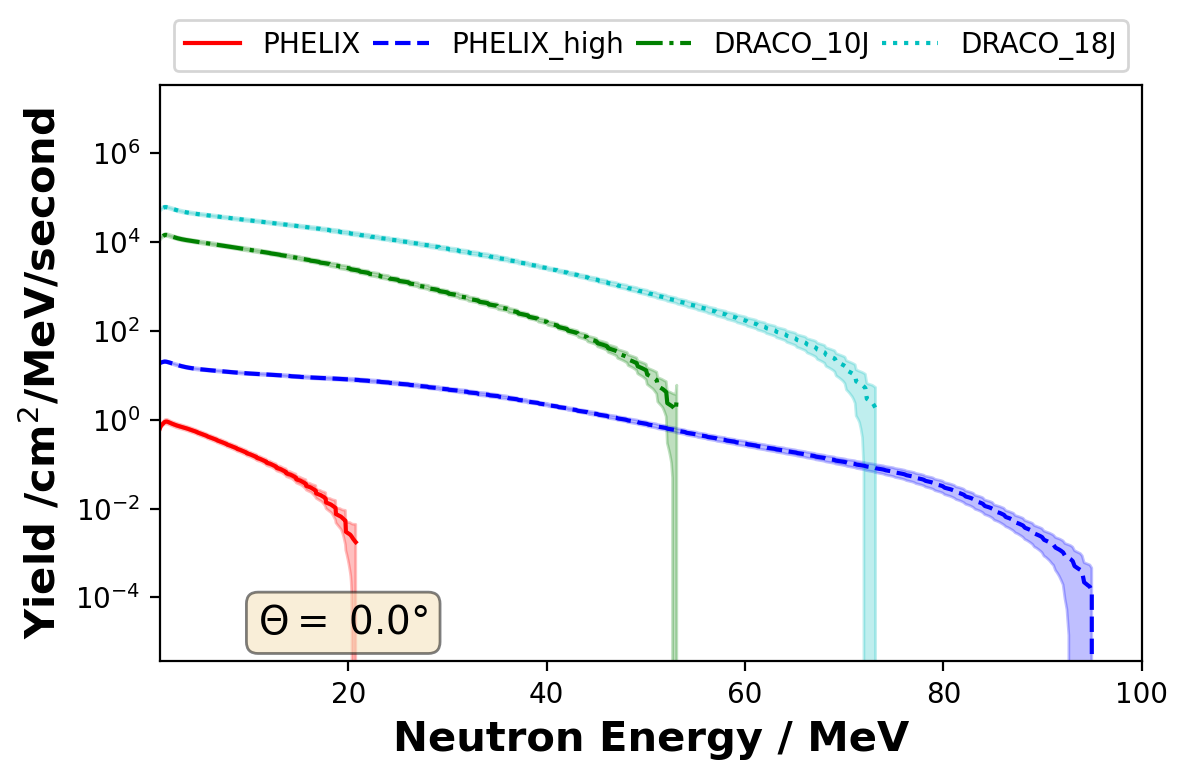

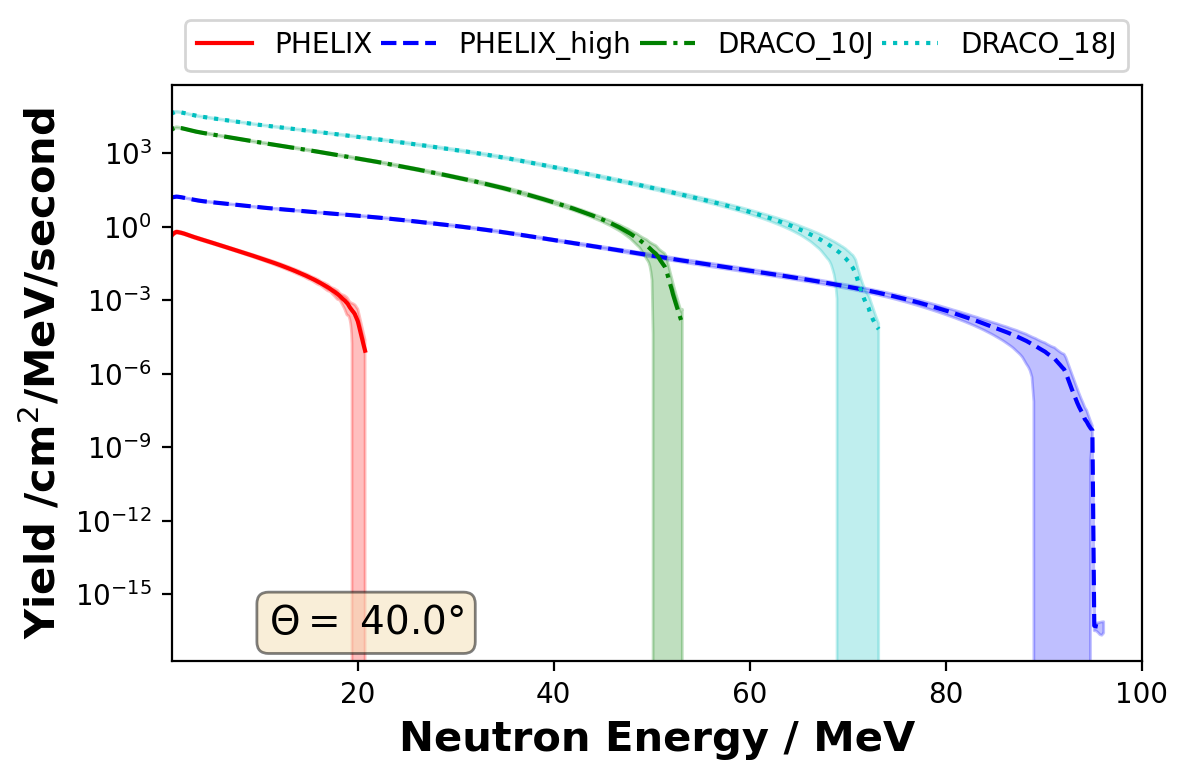

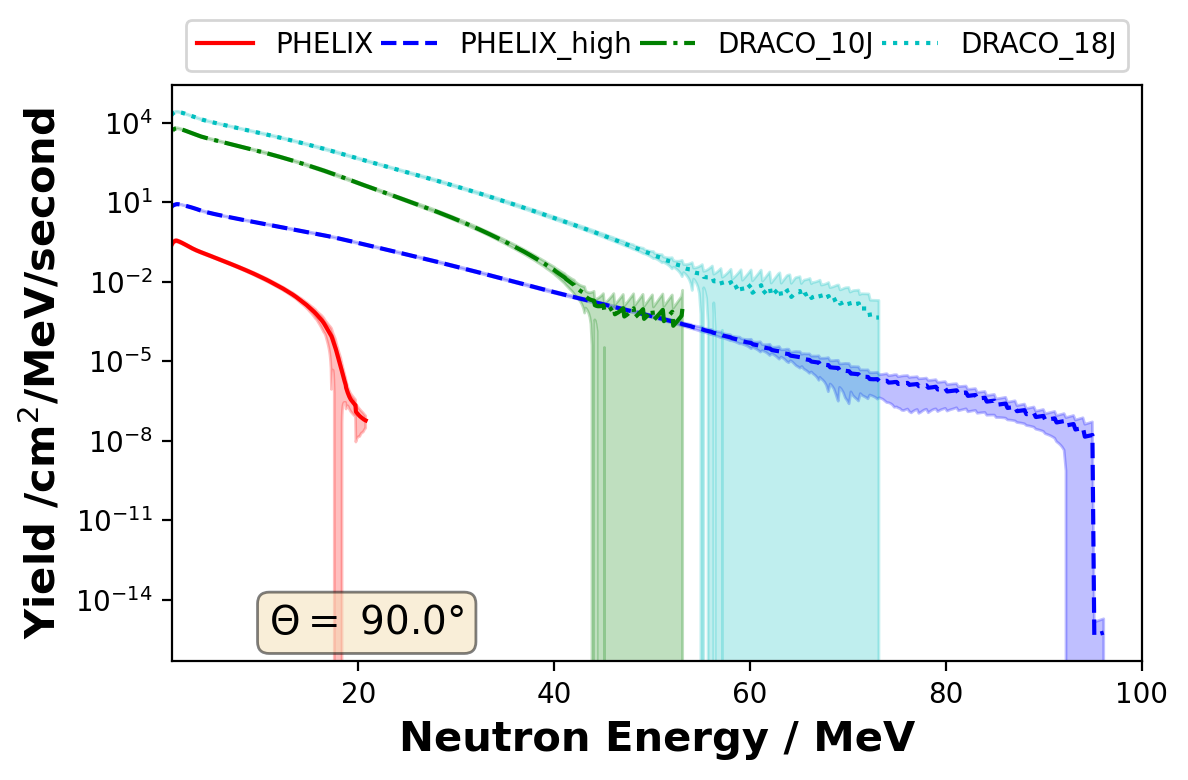

In [55]:
cl = ['r','b','g','c','m','y','k']
props = dict(boxstyle='round', facecolor='white')

CurrentCorrection = True
# plot spectra 
List_of_Machines = TNSA_Setups#Conventional_machines + TNSA_Setups # add TNSA Setup
# xscale
x_scaling = ['log','linear']
# Angles selection
tempAngles = [Angles[x] for x in[0,5,10]]

for theta in tqdm.tqdm(tempAngles):
    f, ax = plt.subplots(dpi=200)

    # n is for the plotcyclelist.
    n=0
    for machine in List_of_Machines:
        if machine in Conventional_machines:
            # Include the Current:
            if CurrentCorrection: CurrentCorr = Conventional_dict[machine]['Current']*6.242E18
            else: CurrentCorr=1
            plotting = Conventional_dict[machine]['data']
            plotting = plotting[plotting[:,3]==theta/180]
            plotting= plotting[plotting[:, 0].argsort()]
            #plt.plot(plotting[:,0]*150,plotting[:,-2]*CurrentCorr, lines[n],label=machine)
            
            plt.plot(plotting[:,0]*150,plotting[:,-2]*CurrentCorr, lines[n],color=cl[n],label=machine)
            plt.fill_between(plotting[:,0]*150, (plotting[:,-2]-2*plotting[:,-1])*CurrentCorr, (plotting[:,-2]+2*plotting[:,-1])*CurrentCorr, color=cl[n], alpha=0.25)


        if machine in TNSA_Setups:
            plotTNSA = prepare_plot_data_TNSA(TNSA_object=TNSA_dict[machine], theta=theta)
            plotTNSA = np.array(plotTNSA)
            x_sorted = plotTNSA[plotTNSA[:, 0].argsort()]#np.sort(plotTNSA, axis=0)
            
            # define label
            if machine == 'MULTI_Emax':
                temp_label = 'Maximal Cut-off'
            elif machine == 'MULTI_Cmax':
                temp_label = 'Maximal Conversion'
            else:
                temp_label = machine

            #x_sorted = plotTNSA[plotTNSA[:, 1].argsort()]
            plt.plot(x_sorted[:,0]*150,x_sorted[:,1]*TNSA_dict[machine]['RepRate']
                     , lines[n],color=cl[n], label=temp_label)
            plt.fill_between(x_sorted[:,0]*150, (x_sorted[:,1]-2*x_sorted[:,2])*TNSA_dict[machine]['RepRate'],(x_sorted[:,1]+2*x_sorted[:,2])*TNSA_dict[machine]['RepRate'],color=cl[n], alpha=0.25)

        n=(n+1)%7

    plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4)
    if CurrentCorrection: plt.ylabel(r'Yield /cm$^2$/MeV/second', fontsize = 15, weight='bold' );
    else: plt.ylabel(r'Yield /cm$^2$/MeV/source', fontsize = 15, weight='bold' );

    plt.xlabel('Neutron Energy / MeV', fontsize = 15, weight='bold' );
    plt.yscale('log')

    #plt.xlim([1E-3,100])#150
    #plt.ylim([1E-15,5E-3])
    #pl.plot([1E-3,150],[1E2,1E2],'k')

    # place a text box in upper left in axes coords
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.1,0.1, r'$\Theta=$ '+str(theta)+'°', size=50,#transform=ax.transAxes, #transform=ax.transAxes, 
             fontsize=14, ha='left', va='top', transform=ax.transAxes,bbox=props)#;6transform=ax.transAxes
    f.tight_layout()
    for xs in x_scaling:
        plt.xscale(xs)
        if xs == 'log':
            plt.xlim([1E-3,100])#150
        elif xs == 'linear':
            plt.xlim([1,100])#150

        #plt.savefig('LiquidPred_'+'proton'+'_'+'beryllium'+'_'+xs+'_'+str(theta)+'.pdf')
    #plt.close()

## Validation Plots with TNSA Simulation

In [11]:
Tdata = pd.read_csv('TNSA_data.csv')
Tsigm = pd.read_csv('TNSA_sigma.csv')
# x_MC is imported above if missing, insert readin here
#x_MC = ValidData[item][0]

100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


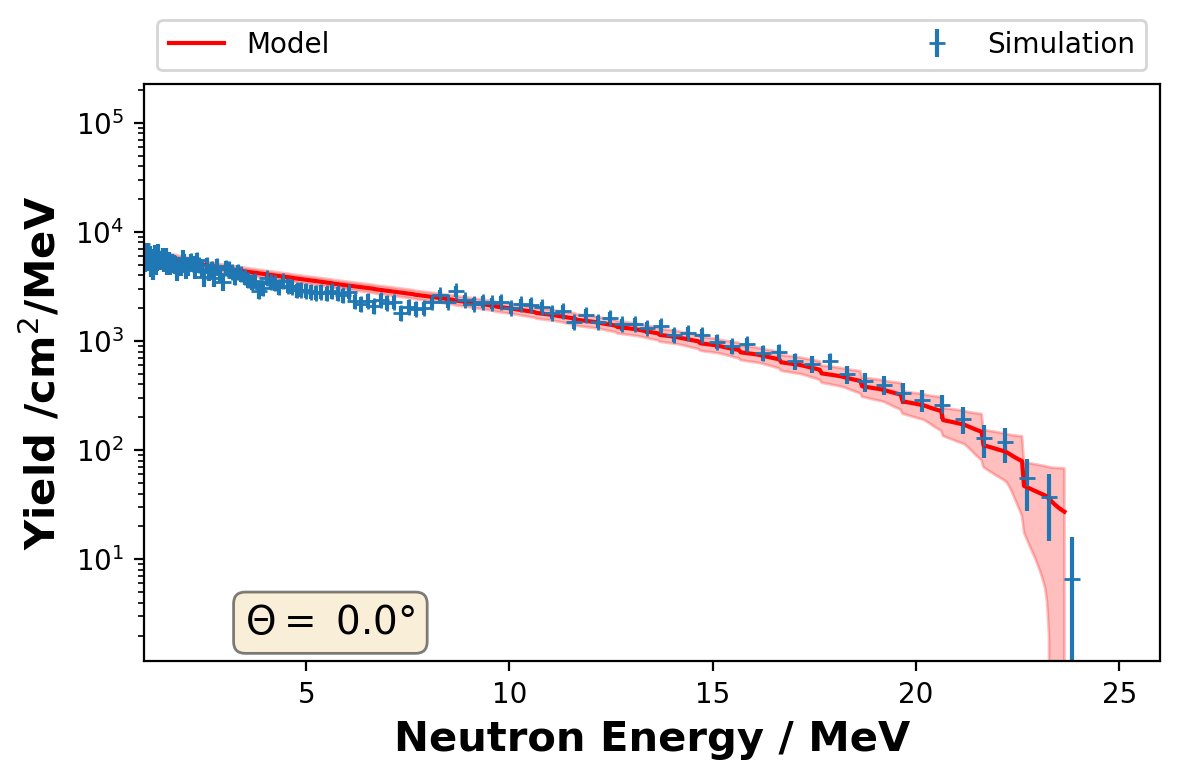

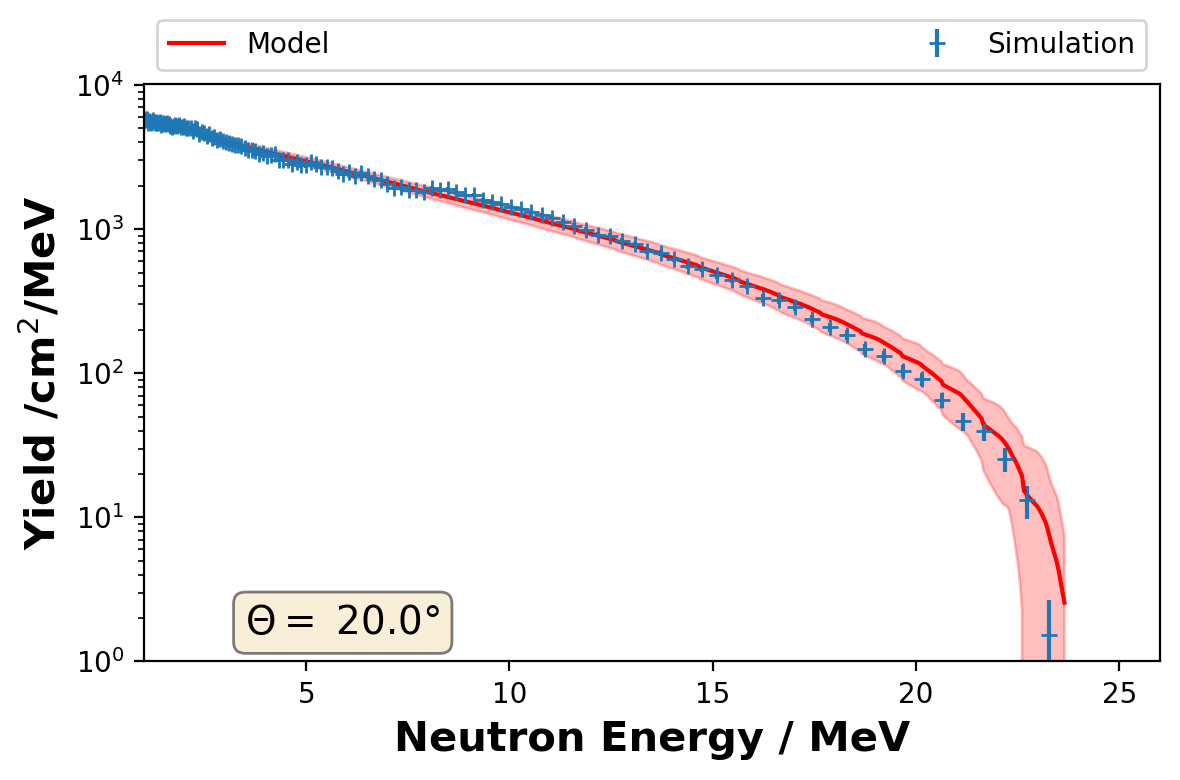

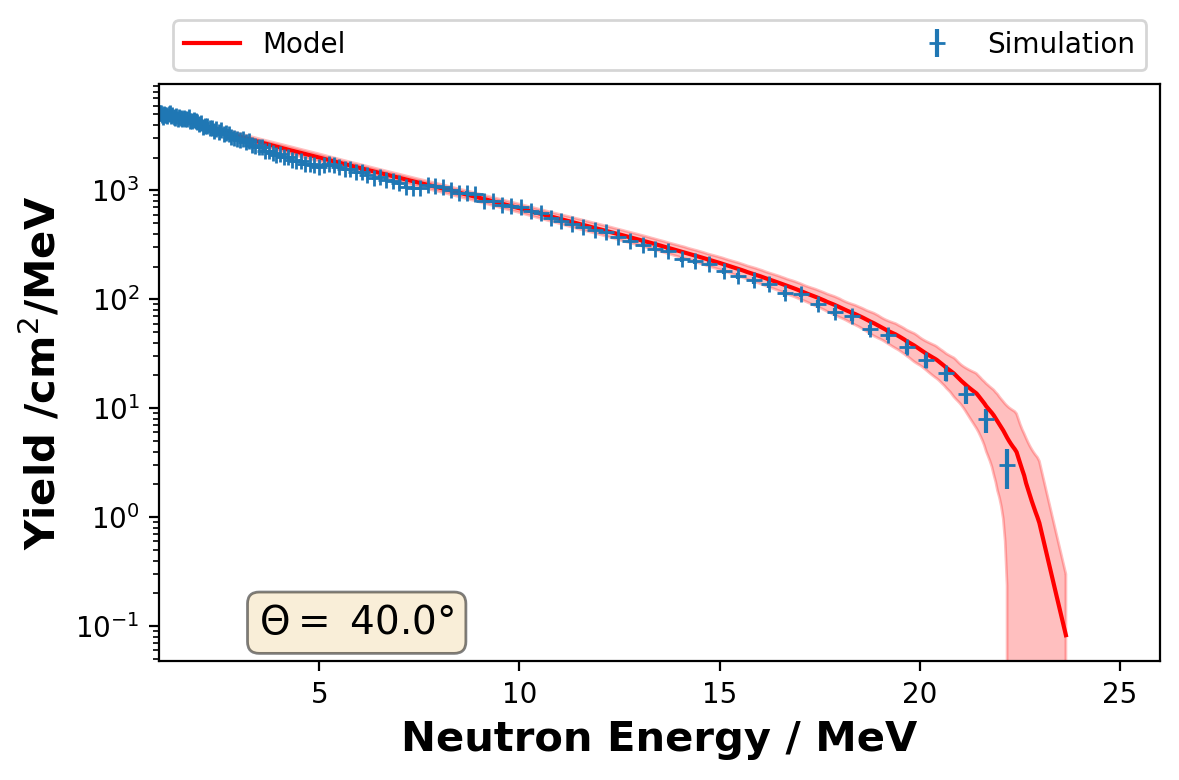

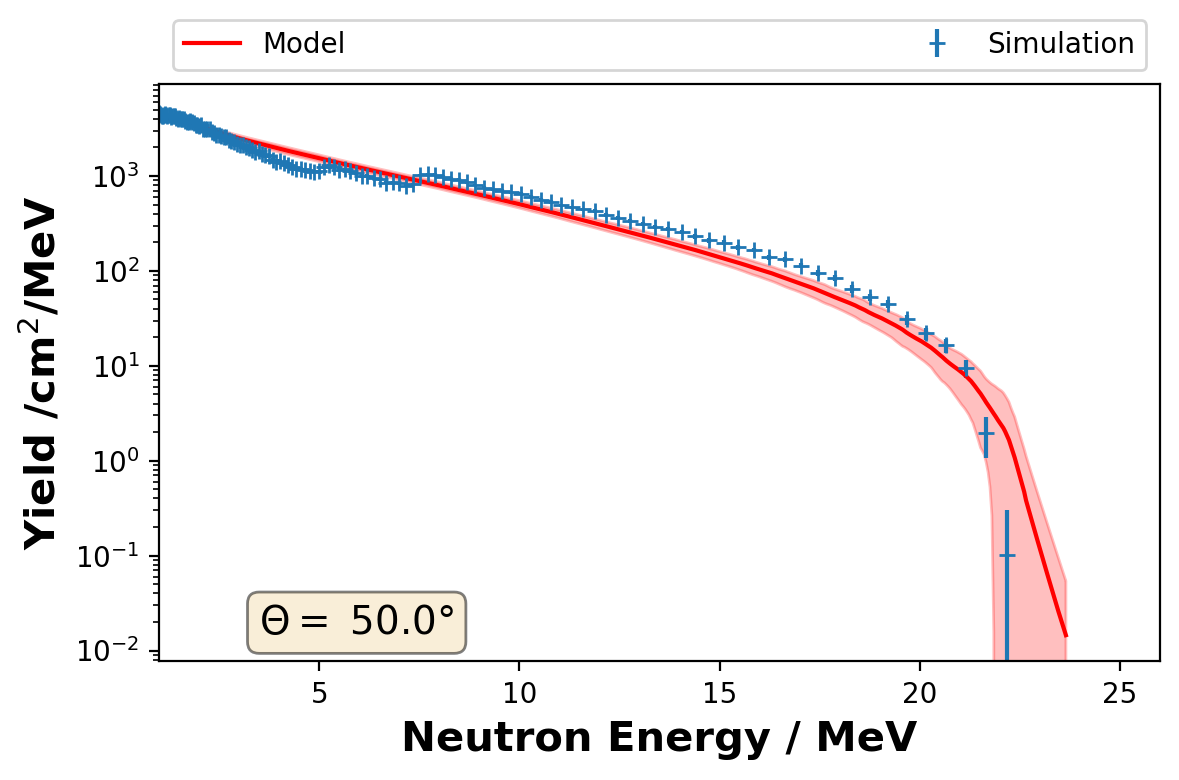

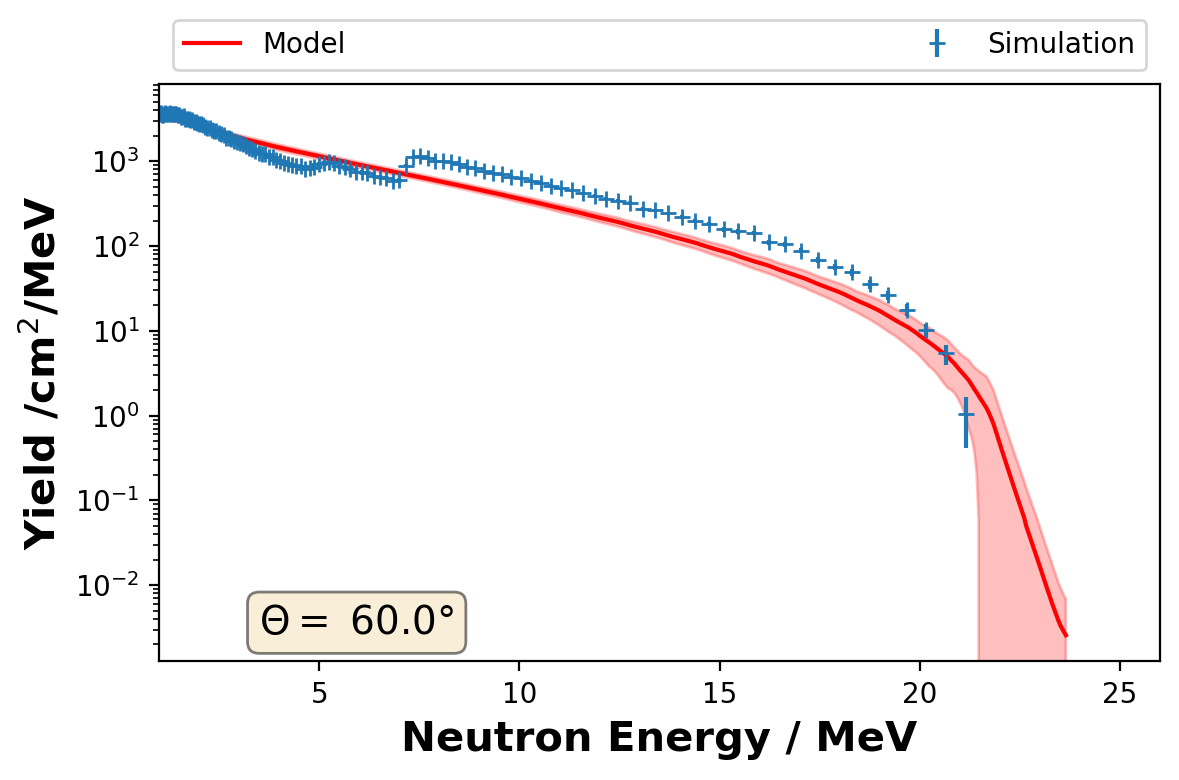

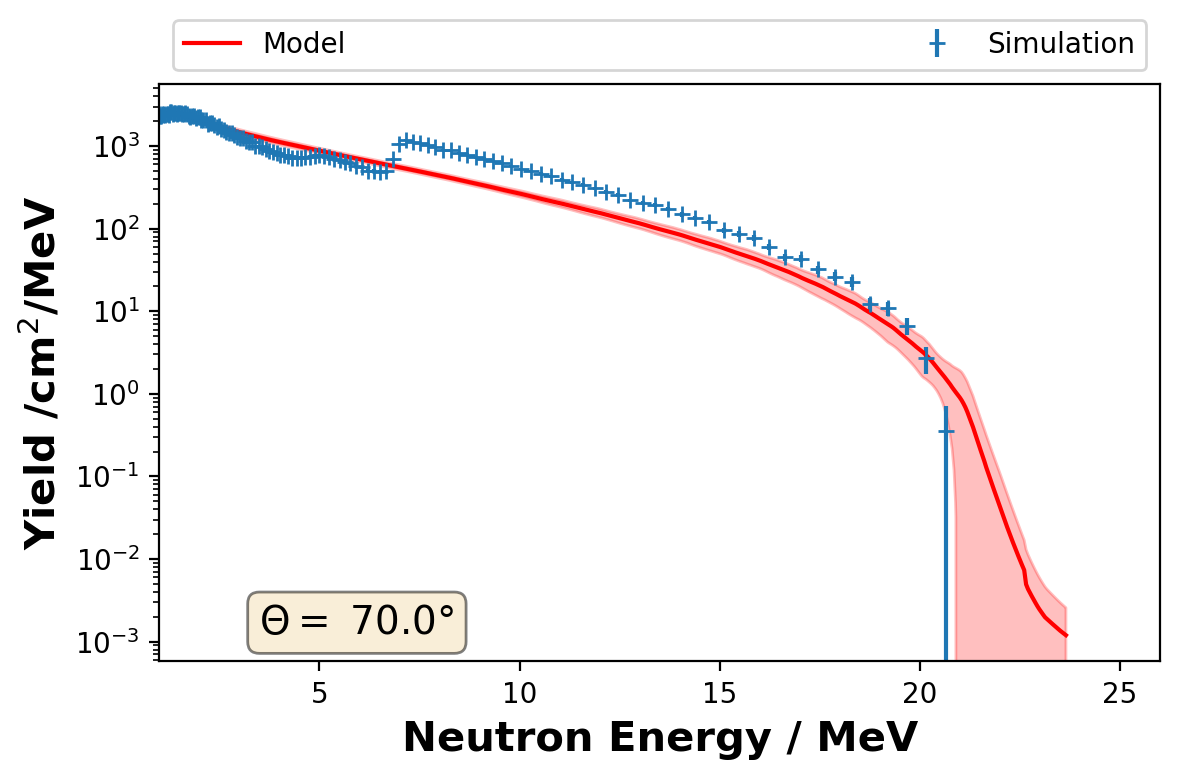

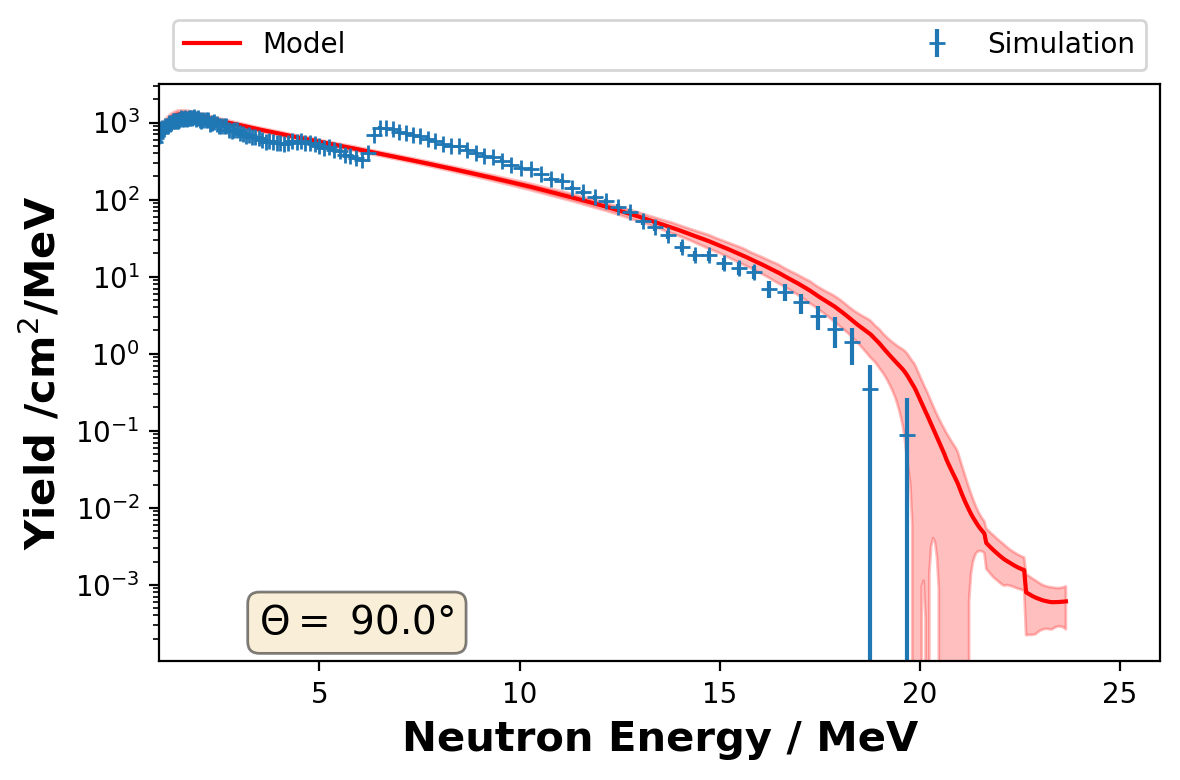

In [91]:
cl = ['r','b','g','c','m','y','k']
props = dict(boxstyle='round', facecolor='white')

CurrentCorrection = False
# plot spectra 
List_of_Machines = TNSA_Setups#Conventional_machines + TNSA_Setups # add TNSA Setup
# xscale
x_scaling = ['log','linear']
# Angles selection
tempAngles = [Angles[x] for x in[0,3,5,6,7,8,10]]

for theta in tqdm.tqdm(tempAngles):
    f, ax = plt.subplots(dpi=200)

    # n is for the plotcyclelist.
    n=0
    
    # plot data first, model second:
    # Plot simulation data:
    if theta == 0.0:
        temp_theta = 2.5
    elif theta==180.0:
        temp_theta = 177.5
    else:
        temp_theta=theta
        
    plot_data = Tdata[Tdata['Angle']==temp_theta]
    plot_sigm = Tsigm[Tsigm['Angle']==temp_theta]
    plt.errorbar(x_MC,plot_data.iloc[0][7:]*1.42115E11,yerr=2*plot_sigm.iloc[0][7:]*plot_data.iloc[0][7:]*1.42115E11, label='Simulation',fmt='+')
    
    for machine in ['LIGHT']:
        if machine in Conventional_machines:
            # Include the Current:
            if CurrentCorrection: CurrentCorr = Conventional_dict[machine]['Current']*6.242E18
            else: CurrentCorr=1
            plotting = Conventional_dict[machine]['data']
            plotting = plotting[plotting[:,3]==theta/180]
            plotting= plotting[plotting[:, 0].argsort()]
            #plt.plot(plotting[:,0]*150,plotting[:,-2]*CurrentCorr, lines[n],label=machine)
            
            plt.plot(plotting[:,0]*150,plotting[:,-2]*CurrentCorr, lines[n],color=cl[n],label=machine)
            plt.fill_between(plotting[:,0]*150, (plotting[:,-2]-2*plotting[:,-1])*CurrentCorr, (plotting[:,-2]+2*plotting[:,-1])*CurrentCorr, color=cl[n], alpha=0.25)


        if machine in TNSA_Setups:
            plotTNSA = prepare_plot_data_TNSA(TNSA_object=TNSA_dict[machine], theta=theta)
            plotTNSA = np.array(plotTNSA)
            x_sorted = plotTNSA[plotTNSA[:, 0].argsort()]#np.sort(plotTNSA, axis=0)
            
            # define label
            if machine == 'MULTI_Emax':
                temp_label = 'Maximal Cut-off'
            elif machine == 'MULTI_Cmax':
                temp_label = 'Maximal Conversion'
            elif machine == 'LIGHT':
                temp_label = 'Model'
            else:
                temp_label = machine

            #x_sorted = plotTNSA[plotTNSA[:, 1].argsort()]
            plt.plot(x_sorted[:,0]*150,x_sorted[:,1]
                     , lines[n],color=cl[n], label=temp_label)
            plt.fill_between(x_sorted[:,0]*150, (x_sorted[:,1]-2*x_sorted[:,2]),(x_sorted[:,1]+2*x_sorted[:,2]),color=cl[n], alpha=0.25)

        n=(n+1)%7

    plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4)
    if CurrentCorrection: plt.ylabel(r'Yield /cm$^2$/MeV/second', fontsize = 15, weight='bold' );
    else: plt.ylabel(r'Yield /cm$^2$/MeV', fontsize = 15, weight='bold' );

    plt.xlabel('Neutron Energy / MeV', fontsize = 15, weight='bold' );
    plt.yscale('log')

    #plt.xlim([1E-3,100])#150
    #plt.ylim([1E-15,5E-3])
    #pl.plot([1E-3,150],[1E2,1E2],'k')

    # place a text box in upper left in axes coords
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.1,0.1, r'$\Theta=$ '+str(theta)+'°', size=50,#transform=ax.transAxes, #transform=ax.transAxes, 
             fontsize=14, ha='left', va='top', transform=ax.transAxes,bbox=props)#;6transform=ax.transAxes
    f.tight_layout()
    for xs in x_scaling:
        plt.xscale(xs)
        if xs == 'log':
            plt.xlim([1E-3,26])#150
        elif xs == 'linear':
            plt.xlim([1,26])#150
    plt.tight_layout()
    plt.savefig('TNSA_Sim_p_Be_'+str(theta)+'.pdf')
    #plt.close()

## Plots for the validation with raw simulation data. 

In [ ]:
import pickle
with open('validcurves.pkl', 'rb') as f:
    ValidData = pickle.load(f)

ValidLabels = list(ValidData.keys())

In [ ]:
ValidLabels

In [ ]:
## Adjust Data for different detector sizes:
AngletoAreas = np.array([#
[2.5, 14.94],
[ 7.5, 44.72],
[ 12.5, 74.15], 
[ 20.0, 234.12], 
[ 30.0, 342.26], 
[ 40.0, 440.00], 
[ 50.0, 524.37], 
[ 60.0, 592.81], 
[ 70.0, 643.24], 
[ 80.0, 674.12], 
[ 90.0, 684.52], 
[ 100.0, 674.12], 
[ 110.0, 643.24], 
[ 120.0, 592.81],  
[ 130.0, 524.37], 
[ 140.0, 440.00], 
[ 150.0, 342.26], 
[ 160.0, 234.12], 
[ 167.5, 74.15], 
[ 172.5, 44.72], 
[ 177.5, 14.94 ]])

AngletoAreas[AngletoAreas[:,0]==2.5][0][1]

In [ ]:
ValidLabels[n*6:(n+1)*6][0].split('_')

In [ ]:
#colorlist
cl = ['r','b','g','c','m','y','k']
props = dict(boxstyle='round', facecolor='white')

for n in range(4):
    for m in ['2.5','90']:
        f, ax = plt.subplots(dpi=200)
        # counter for the color range:
        j=0
        for item in ValidLabels[n*6:(n+1)*6]:
            temp = item.split('_')
            # Only work on theta degree!
            if temp[3] == m:

                x= np.linspace(0,150,300)
                x_in = san_input(En=x, Ep=float(temp[2]), dL=float(temp[4]), Theta=float(temp[3]), 
                                 Proj=temp[0], Conv=temp[1], display_output=False)
                En , Ec = estimate_cutoff(x_in)
                x= np.linspace(0,Ec,6000)
                x_in = san_input(En=x, Ep=float(temp[2]), dL=float(temp[4]), Theta=float(temp[3]), 
                                 Proj=temp[0], Conv=temp[1], display_output=False)

                x_out = calc_spectrum(x_in)
                
                # plot model data
                if m== '2.5':
                    mout = '0'
                else:
                    mout = m
                
                plt.plot(x_out[:,0]*150,x_out[:,8],cl[j], label='M:'+temp[2]+' MeV; '+mout+'°')
                plt.fill_between(x_out[:,0]*150, (x_out[:,8]-2*x_out[:,9]),(x_out[:,8]+2*x_out[:,9]),color=cl[j], alpha=0.5)
                #plt.plot(x_out[:,0]*150,x_out[:,8], label='M:'+temp[2]+' MeV; '+mout+'°')

                x_MC = ValidData[item][0]
                y_MC = ValidData[item][1]
                # correct the Monte Carlo spectra with the correct detetor surface
                correction = AngletoAreas[AngletoAreas[:,0]==float(m)][0][1]
                plt.plot(x_MC,y_MC/correction,'--',color=cl[j], label='D:'+temp[2]+' MeV; '+mout+'°')
                
                j=j+1
                
        ax.text(0.1,0.1, r''+temp[0][0]+'+'+temp[1], size=50,#transform=ax.transAxes, #transform=ax.transAxes, 
                fontsize=14, ha='left', va='top', transform=ax.transAxes,bbox=props)#;6transform=ax.transAxes

        plt.ylabel(r'Yield /cm$^2$/MeV/source', fontsize = 15, weight='bold' );
        plt.xscale('log')

        plt.xlabel('Neutron Energy / MeV', fontsize = 15, weight='bold' );
        plt.yscale('log')

        plt.xlim([1E-2,150])
        plt.ylim([1E-13,1E-3])
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3)
        
        plt.savefig(temp[0]+'+'+temp[1]+'+'+m+".pdf")


In [ ]:
x_out.shape

## Experimental Data Comparison
Here the model is compared with different thick target yield datasets.

In [10]:
def calc_unit_corrections(sr=1, d=100, r=0.1, charge = 1):
    # First correct for solidangle:
    ## it is defined by detecotr area with radius r divided by the radius of the measurement sphere.
    corr_solid_angle = r**2 / d**2
    # Second correction is a rsult from the integrated bunchcurrent.
    ## The model gives the created neutrons per incident particle 
    corr_countrate = 1/charge
    #Third correction is the normalization from detector size to 1/cm^2
    corr_size = 1#np.pi*r**2
    
    return corr_solid_angle*corr_countrate*corr_size

In [15]:
#data_path_exp = 'Howard2001-Data.csv'
#data_path_exp = 'Kamada2011-Data.csv'
data_path_exp = 'Osipenko2013-Data.csv'
#data_path_exp = 'cleanedExpData.csv'
#ExpData = pd.read_csv('cleanedExpData.csv')
if data_path_exp == 'Howard2001-Data.csv':
    ExpData = pd.read_csv(data_path_exp)
    ExpData['Projectile'] = 0
    ExpData['Target'] = 10
    ExpData['Length'] = 0.5
    # unit conversion:
    ycorr = calc_unit_corrections(sr=1, d=1000, r=12.7/2, charge = 6.242E12) # correctionfunction
    
elif data_path_exp == 'Kamada2011-Data.csv':
    ExpData = pd.read_csv(data_path_exp)
    ExpData['Projectile'] = 0
    ExpData['Target'] = 10
    ExpData['Length'] = 2
    # unit conversion:
    ycorr = calc_unit_corrections(sr=1, d=345, r=14/2, charge = 6.242E12) # correctionfunction
    
elif data_path_exp == 'Osipenko2013-Data.csv':
    ExpData = pd.read_csv(data_path_exp)
    ExpData['Projectile'] = 0
    ExpData['Target'] = 10
    ExpData['Length'] = 30
    # unit conversion: Only sr to cm^2 has to be included
    ycorr = calc_unit_corrections(sr=1, d=75, r=4.6/2, charge = 1)*1E6 # correctionfunction
else:
    ExpData = pd.read_csv(data_path_exp)

# Display dataset
ExpData
#set(ExpData['ScatteringAngle'])

Unnamed: 0   NeutronRate  SigmaNeutronRate  IncidentEnergy  \
0         42122  2.683800e-09      4.009150e-10      62000000.0   
1         42123  2.575700e-09      3.769110e-10      62000000.0   
2         42124  2.446800e-09      3.564540e-10      62000000.0   
3         42125  2.633900e-09      3.803510e-10      62000000.0   
4         42126  2.370100e-09      3.414850e-10      62000000.0   
..          ...           ...               ...             ...   
388       42510  1.179500e-10      1.377300e-11      62000000.0   
389       42511  8.398300e-11      9.819740e-12      62000000.0   
390       42512  5.422800e-11      6.356240e-12      62000000.0   
391       42513  3.080200e-11      3.652080e-12      62000000.0   
392       42514  1.226100e-11      1.507480e-12      62000000.0   

     SigmaIncidentEnergy  NeutronEnergy  SigmaNeutronEnergy  ScatteringAngle  \
0                   -0.0       490000.0             20000.0              0.0   
1                   -0.0       590000.0             30000.0              0.0   
2                   -0.0       655000.0             35000.0              0.0   
3                   -0.0       730000.0             40000.0              0.0   
4                   -0.0       815000.0             45000.0              0.0   
..                   ...            ...                 ...              ...   
388                 -0.0      5445000.0            635000.0            150.0   
389                 -0.0      6975000.0            895000.0            150.0   
390                 -0.0      9190000.0           1320000.0            150.0   
391                 -0.0     12535000.0           2025000.0            150.0   
392                 -0.0     17850000.0           3290000.0            150.0   

     SigmaScatteringAngle       Author  Year  Projectile  Target  Length  
0                    -0.0  M.Osipenko+  2013           0      10      30  
1                    -0.0  M.Osipenko+  2013           0      10      30  
2                    -0.0  M.Osipenko+  2013           0      10      30  
3                    -0.0  M.Osipenko+  2013           0      10      30  
4                    -0.0  M.Osipenko+  2013           0      10      30  
..                    ...          ...   ...         ...     ...     ...  
388                  -0.0  M.Osipenko+  2013           0      10      30  
389                  -0.0  M.Osipenko+  2013           0      10      30  
390                  -0.0  M.Osipenko+  2013           0      10      30  
391                  -0.0  M.Osipenko+  2013           0      10      30  
392                  -0.0  M.Osipenko+  2013           0      10      30  

[393 rows x 14 columns]

In [16]:
# Sort pandas data frame into model ideal data array.
x_data = np.zeros((ExpData.shape[0],10))

# x_in[:,0] = En[i]           /150 # neutron energy bin
# x_in[:,1] = Ep              /100 # projectile energy
# x_in[:,2] = dL              /105 # length
# x_in[:,3] = TempTheta       /180 # angle
# x_in[:,4] = TempProj             # OHE P
# x_in[:,5] = int(TempConv[0])     # OHE T1
# x_in[:,6] = int(TempConv[1])     # OHE T2
# x_in[:,7] = int(TempConv[2])     # OHE T3

x_data[:,0] = ExpData['NeutronEnergy'].to_numpy()/150E6
x_data[:,1] = ExpData['IncidentEnergy'].to_numpy()/100E6
x_data[:,2] = ExpData['Length'].to_numpy()/105
x_data[:,3] = ExpData['ScatteringAngle'].to_numpy()/180
x_data[:,4] = ExpData['Projectile'].to_numpy()
x_data[:,5] = ExpData['Target'].to_numpy()
x_data[:,6] = ExpData['Target'].to_numpy()
x_data[:,7] = ExpData['Target'].to_numpy()

# check where it is 100 and set that value, rest is zero!
temp_data = np.zeros((ExpData.shape[0]))
temp_data[x_data[:,5] == 100] = 1
x_data[:,5] = temp_data

# check where it is 10 and set that value, rest is zero!
temp_data = np.zeros((ExpData.shape[0]))
temp_data[x_data[:,6] == 10] = 1
x_data[:,6] = temp_data

#last bit is always 0 due to the element distribution
temp_data = np.zeros((ExpData.shape[0]))
#temp_data[x_data[:,6] == 10] = 1
x_data[:,7] = temp_data

## 
x_data[:,8] = ExpData['NeutronRate'].to_numpy()*ycorr#/1.265E18 # 1.265E9
x_data[:,9] = ExpData['SigmaNeutronRate'].to_numpy()*ycorr#/1.265E18 # 1.265E9

#Compare Model with experiment:
reddata = x_data[x_data[:,4]==0] # particle type 0 = proton
reddata = reddata[reddata[:,5]==0] # OHE target type 010 = Beryllium
reddata = reddata[reddata[:,6]==1]
reddata = reddata[reddata[:,7]==0]

# select incident energy: 
selected_energy = list(set(reddata[:,1]))
selected_energy.sort()

reddata = reddata[reddata[:,1]==selected_energy[0]]

# select converter length: 
length_select = 0 # the index of the selected converter length
reddata = reddata[reddata[:,2]==list(set(reddata[:,2]))[length_select]]
if len(set(reddata[:,3]))==1:
    print('Data reduction sufficient!')
    
## select angle!    
#reddata = reddata[reddata[:,3]==list(set(reddata[:,3]))[2]]

0.0
Cut-off energy is 0.6015 or 60.15 MeV
Converter Lengh:
30.0
Scattering Angle Used:
0.0
Identified Proton Projectile.
Target identified as: be
Projectile Energy:
62.0
Spectrum suddessfully generated; 300 samples generated.


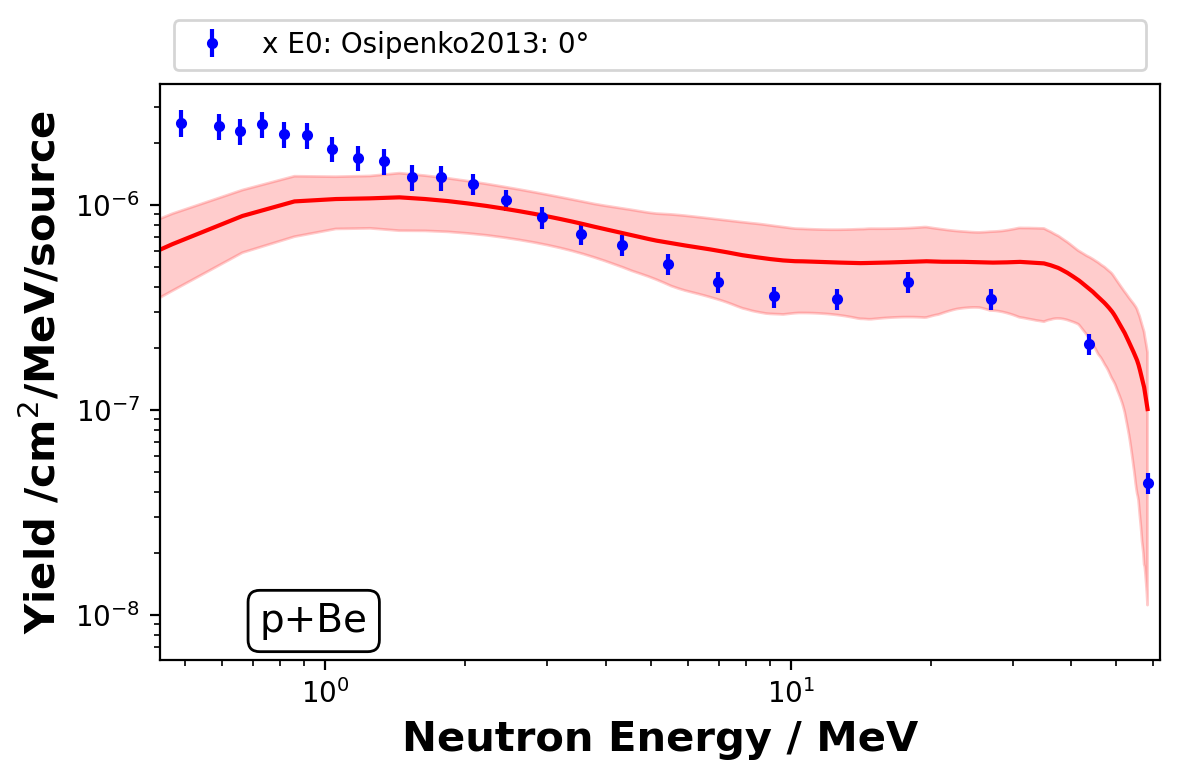

In [33]:
#colorlist
cl = ['r','b','g','c','m','y','k','r','b','g','c','m','y','k','r','b','g','c','m','y','k','r','b','g','c','m','y','k']
marks = ['.','1','2','3','4','_','x','+','d','s','p','.','1','2','3','4','_','x','+','d','s','p','.','1','2','3','4','_','x','+','d','s','p']
props = dict(boxstyle='round', facecolor='white')

# create labels:
## Reaction 
Proj=int(reddata[0,4])
Conv=str(int(reddata[0,5]))+str(int(reddata[0,6]))+str(int(reddata[0,7]))
#Angl=Theta=reddata[0,3]*180

Ep = reddata[0,1]*100

# check for projectile
if Proj == 0:
    prStr = 'p'
elif Proj == 1:
    prStr = 'd'
else:
    prStr='??'
# check for converter
if Conv == '000':
    CoStr = 'Li'
elif Conv == '001':
    CoStr = 'LiF'
elif Conv == '010':
    CoStr = 'Be'

StringBox = prStr+'+'+CoStr#+': '+str(Angl)+'°'

# plot model data
f, ax = plt.subplots(dpi=200)


angles = list(set(reddata[:,3]))
angles.sort()
angles = angles[0:1]
# select angle!    
for j in range(len(angles)):

    reddata_Temp = reddata[reddata[:,3]==angles[j]]
    
    print(angles[j])

    # x_in[:,0] = En[i]           /150 # neutron energy bin
    # x_in[:,1] = Ep              /100 # projectile energy
    # x_in[:,2] = dL              /105 # length
    # x_in[:,3] = TempTheta       /180 # angle
    # x_in[:,4] = TempProj             # OHE P
    # x_in[:,5] = int(TempConv[0])     # OHE T1
    # x_in[:,6] = int(TempConv[1])     # OHE T2
    # x_in[:,7] = int(TempConv[2])     # OHE T3

    x= np.linspace(0,150,300)

    x_in = reddata_Temp[:,0:8]
    En , Ec = estimate_cutoff(x_in)
    # reduce the x domain for plotting:
    Ec = np.max(reddata_Temp[:,0]*150)
    x= np.linspace(8E-2,Ec,300)
    x_in = san_input(En=x, Ep=reddata_Temp[0,1]*100, dL=reddata_Temp[0,2]*105, Theta=reddata_Temp[0,3]*180, 
                     Proj=int(reddata_Temp[0,4]), Conv=str(int(reddata_Temp[0,5]))+str(int(reddata_Temp[0,6]))+str(int(reddata_Temp[0,7])), 
                     display_output=True)

    x_out = calc_spectrum(x_in)

    # draw plots

    #plt.plot(x_out[:,0]*150,x_out[:,8])

    plt.plot(x_out[:,0]*150,x_out[:,8]*10**(3*j),cl[j])#, label='Model at '+str(Ep)+' MeV/u')
    plt.fill_between(x_out[:,0]*150, (x_out[:,8]-2*x_out[:,9])*10**(3*j),(x_out[:,8]+2*x_out[:,9])*10**(3*j),color=cl[j], alpha=0.2)

    # plot experimental data
    plt.errorbar(reddata_Temp[:,0]*150,reddata_Temp[:,-2]*10**(3*j),yerr=reddata_Temp[:,-1]*10**(3*j),fmt=marks[j],color=cl[j+1], label='x E'+str(3*j)+': '+data_path_exp.split('-')[0]+': '+str(int(angles[j]*180))+'°')

plt.ylabel(r'Yield /cm$^2$/MeV/source', fontsize = 15, weight='bold' );
plt.xscale('log')

plt.xlabel('Neutron Energy / MeV', fontsize = 15, weight='bold' );
plt.yscale('log')
plt.xlim([reddata[0,0]*150*0.9,Ep])

ax.text(0.1,0.1, r''+StringBox, size=50,#transform=ax.transAxes, #transform=ax.transAxes, 
        fontsize=14, ha='left', va='top', transform=ax.transAxes,bbox=props)#;6transform=ax.transAxes
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2);
plt.tight_layout()

plt.savefig("ExpData_"+data_path_exp.split('-')[0]+".pdf")